<a href="https://colab.research.google.com/github/Chenzhang0329/StockPrice-Hybrid-Model-/blob/main/Final_Assignment_Main_04_01_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Forecasting with a Hybrid Deep Learning Model

# 1.0 Introduction

#2.0 Data Collection and Preprocessing


##2.1 Imports and Configurations

In [ ]:
#Import necessary libraries 
import pandas as pd
!pip install yfinance
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from time import time
from google.colab import files
import yfinance as yf
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns
!pip install transformers
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
import multiprocessing as mp
import datetime as dt
from multiprocessing import Process



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 20.6 MB/s eta 0:00:00


In [ ]:
#configure sentiment analysis pipeline
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
nlp = pipeline("sentiment-analysis", model = finbert, tokenizer = tokenizer)
sentiment_dict = {'Negative':-1, 'Neutral':0, 'Positive': 1}
ticker_list = ['MSFT','GOOG', 'AMZN','TSLA','NFLX']
#clone git repo into workspace
!git clone https://github.com/Chenzhang0329/StockPrice-Hybrid-Model-.git

Cloning into 'StockPrice-Hybrid-Model-'...
remote: Enumerating objects: 237, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 237 (delta 1), reused 0 (delta 0), pack-reused 230
Receiving objects: 100% (237/237), 6.65 MiB | 12.05 MiB/s, done.
Resolving deltas: 100% (112/112), done.


## 2.2 Setup of Data Collection Functions

In [ ]:
# Retrieve financial info from active directory and feature engineer to scale the outcomes to the value of the mean sentiment scores *  count^2
from sklearn.preprocessing import MinMaxScaler
def pull_news(ticker):
    path = '/content/StockPrice-Hybrid-Model-/News Data/'+ticker+'_news.csv'
    news_df = pd.read_csv(path)
    news_list = news_df['headline'].to_list()
    print('success1')
    result = nlp(news_list)
    print('success2')
    result = pd.DataFrame(result)
    news_df["sentiment"] = [sentiment_dict[k]for k in result['label']]  
    news_df['date'] = pd.to_datetime(news_df['date'], format = '%d-%m-%Y')
    sentiment = pd.DataFrame()
    sentiment['mean'] = news_df.groupby(by="date")["sentiment"].mean()
    sentiment['count']= news_df.groupby(by='date')['sentiment'].count()
    sentiment['score'] = sentiment['mean'] * (sentiment['count']**2)
    sentiment = sentiment.fillna(0)
    scaler1 = MinMaxScaler()
    sentiment['score'] = scaler1.fit_transform(sentiment[['score']])
    path3 = ticker+'_sentimentscore.csv'
    sentiment.to_csv(path3)  

#retrieve financial information using yfinance
def get_financials(ticker, start):
    time_delt = dt.timedelta(days = 150)
    start_day = start - time_delt
    data = yf.download(str(ticker), start_day)
    data['ticker'] = ticker
    data = data.reset_index()
    print('success!')
    return data

#Caclulate Exponential moving average
def EWMA(data, ndays): 
    EMA = pd.Series(data['close'].ewm(span = ndays, min_periods = ndays - 1).mean(), 
                 name = 'EWMA_' + str(ndays)) 
    data = data.join(EMA) 
    return data

# Calculate Relative Strength Index
def rsi(close, periods = 14):
    
    close_delta = close.diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

# Calculate Bollinger Bands
def BBANDS(data, window):
    MA = data.close.rolling(window).mean()
    SD = data.close.rolling(window).std()
    data['MiddleBand'] = MA
    data['UpperBand'] = MA + (2 * SD) 
    data['LowerBand'] = MA - (2 * SD)
    return data

# Rolling averages for 10,20,50, and 100 days  feature engineering
def prep_financials(df):
    df = pd.DataFrame(df)
    df.set_index('date')
    df['target'] = (df['close'])
    df['10mda'] = df['close'].rolling(10).mean()
    df['20mda'] = df['close'].rolling(20).mean()
    df['50mda'] = df['close'].rolling(50).mean()
    df['100mda'] = df['close'].rolling(100).mean()
    #df['target'] = [1 if df['pct_change'].loc[i] >0.005 else 0 for i in df.index]
    df = EWMA(df, 20)
    df = EWMA(df, 50) 
    df = EWMA(df, 100)
    df['rsi'] = rsi(df['close'])
    df = BBANDS(df, 20)
    #df.drop(['pct_change'], axis=1, inplace=True)
    df.reset_index()
    return df

In [ ]:
#parallel process to calculate all sentiment scores and process sentiment data into csv files
import datetime as dt
if __name__ == "__main__":
    ticker_list = ['MSFT','GOOG', 'AMZN','TSLA','NFLX']
    processes = []
    proc = Process(target=pull_news)
    processes.append(proc)
    proc.start()

    for tick in ticker_list:
        proc = Process(target =pull_news, args=(tick,))
        processes.append(proc)
        proc.start()
    
    for proc in processes:
        proc.join()


Process Process-1:
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
TypeError: pull_news() missing 1 required positional argument: 'ticker'


success1success1

success1
success1
success1
success2
success2
success2
success2
success2


In [ ]:
#Complete financial info retrieval
finance_dfs = []
for tick in ticker_list:
    data = get_financials(tick, dt.date(2018,1, 1))
    data.rename(columns = {'Date':'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close','Adj Close': 'adj_close', 'Volume':'volume'}, inplace = True)
    print(data.info())
    prepped = prep_financials(data)
    finance_dfs.append(prepped)

#read finance data to csv
full_finance = pd.concat(finance_dfs)
full_finance.to_csv('finance.csv', index = False)
print(full_finance.head(20))

[*********************100%***********************]  1 of 1 completed
success!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1424 entries, 0 to 1423
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1424 non-null   datetime64[ns]
 1   open       1424 non-null   float64       
 2   high       1424 non-null   float64       
 3   low        1424 non-null   float64       
 4   close      1424 non-null   float64       
 5   adj_close  1424 non-null   float64       
 6   volume     1424 non-null   int64         
 7   ticker     1424 non-null   object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 89.1+ KB
None
[*********************100%***********************]  1 of 1 completed
success!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1424 entries, 0 to 1423
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     ------------

#  3.0 Exploratory Data Analysis(EDA) and Data Cleaning
All data collection and initial prep is completed at this point.

In [ ]:
#retrieve sentiment scores and create dataframes with only score and date columns
sentiment_dfs = []
for i in ticker_list:
  data = pd.read_csv('/content/StockPrice-Hybrid-Model-/Sentiment Score/'+i+'_sentimentscore.csv')
  data['date'] = pd.to_datetime(data['date'])
  df = data[['date','score']]
  sentiment_dfs.append(df)
  #check for outstanding NA values
  print(df['score'].isna().sum())
#Check distribution of sentiment dataframe
print(sentiment_dfs[1].describe())

0
0
0
0
0
             score
count  1410.000000
mean      0.347804
std       0.046656
min       0.000000
25%       0.343666
50%       0.345013
75%       0.349057
max       1.000000


## 3.1 Create Final Dataframes to Include Both Sentiment Data and Financial Data 

In [ ]:
financials = pd.read_csv('finance.csv')
#function to separate dataframe by company
def separate_companies(ticker, df):
    dataframe = df[df['ticker']==ticker]
    return dataframe

#separate dataframes for each company and add new features
df_list = []
for tick in ticker_list:
    data = separate_companies(tick, financials)
    data.reset_index()
    data['date'] = pd.to_datetime(data['date'])
    df_list.append(data)

print(sentiment_dfs[1].info())
print(df_list[1].info())
goog = df_list[1].set_index('date').join(sentiment_dfs[1].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[1].mean())
msft = df_list[0].set_index('date').join(sentiment_dfs[0].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[0].mean())
amzn = df_list[2].set_index('date').join(sentiment_dfs[2].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[2].mean())
tesla = df_list[3].set_index('date').join(sentiment_dfs[3].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[3].mean())
nflx = df_list[4].set_index('date').join(sentiment_dfs[4].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[4].mean())

frames = [goog, msft, amzn, tesla, nflx]

print(frames[1])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1410 entries, 0 to 1409
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1410 non-null   datetime64[ns]
 1   score   1410 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 22.2 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1424 entries, 1424 to 2847
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1424 non-null   datetime64[ns]
 1   open        1424 non-null   float64       
 2   high        1424 non-null   float64       
 3   low         1424 non-null   float64       
 4   close       1424 non-null   float64       
 5   adj_close   1424 non-null   float64       
 6   volume      1424 non-null   int64         
 7   ticker      1424 non-null   object        
 8   target      1424 non-null   float64       
 9   10mda     

<ipython-input-6-bbe5864b1c94>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])
<ipython-input-6-bbe5864b1c94>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])
<ipython-input-6-bbe5864b1c94>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

## 3.2 EDA to Explore Change in Stock Prices and Daily Headlines

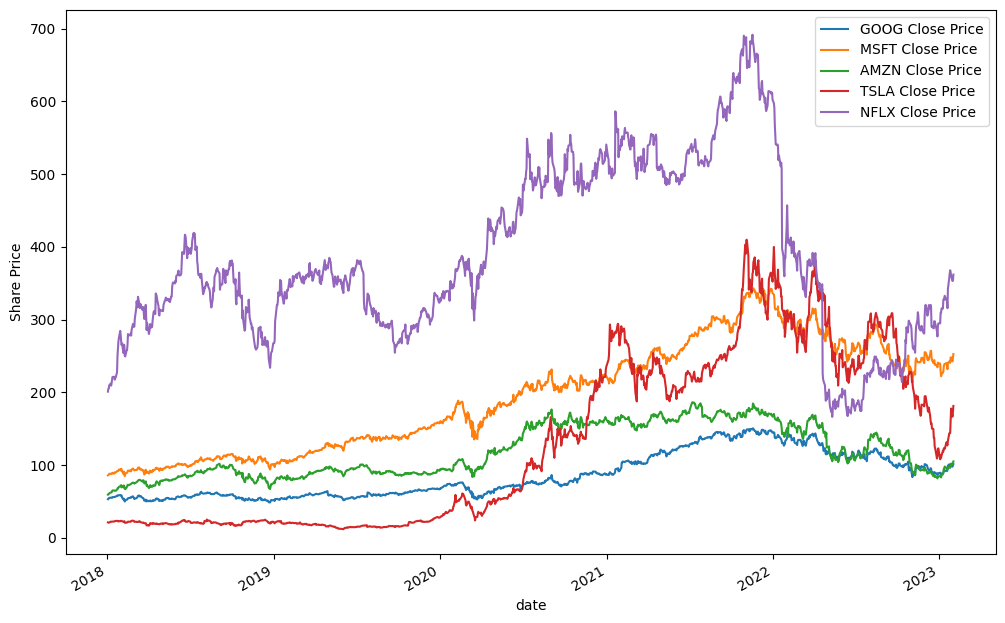

KeyError: ignored

In [ ]:
#EDA and summary stats for compiled datasets
ticker_list = ['GOOG', 'MSFT','AMZN','TSLA','NFLX']
plt.figure(figsize = (12, 8))
frames = [goog, msft, amzn, tesla, nflx]
#create plot to display change in share price
for i, frame in enumerate(frames):
  frame['close'].plot(label = ticker_list[i]+' Close Price')
plt.ylabel('Share Price')
plt.legend()
plt.show()

#create plot to display daily number of headlines as a 20 day rolling average 
rollings = []
for i, frame in enumerate(frames):
  frame['average headlines'] = frame['headline'].rolling(20).mean()
  rollings.append(frame)
plt.figure(figsize = (12, 8))
for i, frame in enumerate(rollings):
  frame['average headlines'].plot(label = ticker_list[i]+' # Daily Headlines')
plt.legend()
plt.ylabel('20 Day Rolling Average Number of Headlines ')
plt.show()


## 3.3 Scale Data and Configure Training/Test Datasets 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# drop irrevelant columns
data = frames[1] # data for microsoft
data = data.drop(['ticker'],axis=1)
 
# features and target columns
target_scaler = MinMaxScaler()
target = target_scaler.fit_transform(data[['target']])
score = data['score']
X_feat = data.drop(['target', 'score'], axis = 1)

# Normalise the data
for col in X_feat.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    X_feat[col] = scaler.fit_transform(X_feat[[col]])
X_feat['score'] = score
X_ft = np.array(X_feat)
# Creating a data structure with 10 time-steps and 1 output
 
# Split data into X_train and y_train data sets
def lstm_split(data,target,steps):
  X = []
  y = []
  # Creating a data structure with 10 time-steps and 1 output
  for i in range(10, steps):
      X.append(data[i-10:i])
      y.append(target[i])  
  return np.array(X),np.array(y)
 
X1,y1 = lstm_split(X_feat,target,len(X_ft))
 

 # function to split  data 90% training-10% testing
def train_split(x1, y1, train_data):
  split = 0.9
  split_idx = int(np.ceil(len(X1)*split))
  date_index = train_data.index
 
  X_train,X_test = X1[:split_idx],X1[split_idx:]
  y_train,y_test = y1[:split_idx],y1[split_idx:]
  X_train_date,X_test_date = date_index[:split_idx],date_index[split_idx:]
  return X_train, X_test, y_train, y_test
  
X_train, X_test, y_train, y_test = train_split(X1, y1, frames[1])
print(X1.shape,X_train.shape,X_test.shape,y_test.shape,y_train.shape)

(1270, 10, 18) (1143, 10, 18) (127, 10, 18) (127, 1) (1143, 1)


# 4.0 Single Company Model Implementation

This section contains the necessary code to define our model and train/test the standalone LSTM as well as the hybrid ensemble model. 

## 4.1 Build  & Validate the LSTM Model on Microsoft Stock
The general architecture of the model is available below. Specific hyperparameters will be defined during the training process using RandomSearch.

In [ ]:
#LSTM Framework for MSFT
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.metrics import Precision
from keras.optimizers import Adam
!pip install keras_tuner
import keras_tuner


#define function to create model, optional hyperparameters included to be selected during training
LR = 0.05
EPOCH = 200
BATCH = 24
def build_model(hp):
  model = Sequential()
  hidden = hp.Choice('n_hidden', [0,1,2,3])
  model.add(LSTM(units = hp.Int('neurons_visible', min_value = X_train.shape[2], max_value = 100, step = 20),
                activation = hp.Choice('activate1', ['sigmoid', 'relu']),
                input_shape = (X_train.shape[1], X_train.shape[2]),
                return_sequences = True if hidden >0 else False))
  
  #Configure hidden layers based on random search determined hidden layer number
  if hidden > 0:
    for num in range(hidden):
      model.add(Dropout(hp.Float('dropout' +str(num+1), min_value = 0.1, max_value = 0.9, step = 0.3)))
      model.add(LSTM(units = hp.Int('neurons_hidden'+str(num+1), min_value = 20, max_value = 50, step = 10),
                     activation = 'relu', return_sequences = True if num != hidden else False))
      
  model.add(Dropout(0.5))
  model.add(Dense(units = 1))

  #compile the model
  model.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = ['mean_squared_error'])
  
  return model

#set learning rate and early stopping callbacks
LR_decay = ReduceLROnPlateau('loss', patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
Early_stop = EarlyStopping(monitor='loss', min_delta=0, 
                           patience=25, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
#arrange random search class
tune = keras_tuner.RandomSearch(build_model, objective= keras_tuner.Objective('val_loss', direction='min'), max_trials = 50, seed = 2)

#complete training 
tune.search(X_train, y_train, epochs = EPOCH, batch_size = BATCH, validation_data = (X_test, y_test), callbacks = [LR_decay, Early_stop])

LSTM_model = tune.get_best_models()[0]

#validating the training
test_predictions = LSTM_model.evaluate(X_train, y_train)
print(test_predictions)
LSTM_model.save('/content/StockPrice-Hybrid-Model-/Models/LSTM_model.h5')
hyperparameters = tune.get_best_hyperparameters(1)[0]
print(hyperparameters.values)

Trial 50 Complete [00h 00m 35s]
val_loss: 0.006137101445347071

Best val_loss So Far: 0.0009780362015590072
Total elapsed time: 00h 35m 40s
36/36 [==============================] - 1s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012
[0.0012397316750138998, 0.0012397316750138998]
{'n_hidden': 0, 'neurons_visible': 98, 'activate1': 'sigmoid', 'dropout1': 0.4, 'neurons_hidden1': 20, 'dropout2': 0.7, 'neurons_hidden2': 50, 'dropout3': 0.1, 'neurons_hidden3': 50}


##4.2 LSTM Model Testing

### 4.2.2 Evaluate LSTM Model Success on MSFT Test Data

In [ ]:
# function to test LSTM predictions
def testmodel(m_path, trainset ):
  from keras.models import load_model
  model = load_model(m_path)
  return model.predict(trainset)


In [ ]:
#test LSTM model using X_train for MSFT
LSTM_MSFT_yhat = testmodel('/content/StockPrice-Hybrid-Model-/Models/LSTM_model.h5', X_train)
LSTM_MSFT_yhat.shape

36/36 [==============================] - 1s 10ms/step


(1143, 1)

### 4.2.1 Format Test Data to Reflect Training Data for Google Stock

In [ ]:
# prep google test data
google = frames[0]
google_scaler = MinMaxScaler()
google_target = google_scaler.fit_transform(google[['target']])
google_score = google['score']
test_ft = google.drop(['target', 'score', 'ticker'], axis = 1)

# Normalise the data
for col in test_ft.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    test_ft[col] = scaler.fit_transform(test_ft[[col]])
test_ft['score'] = google_score
test_ft = np.array(test_ft)

google_ft, google_target = lstm_split(test_ft,google_target,len(google_score))

In [ ]:
#test LSTM model using X_train for GOOG
LSTM_GOOG_yhat = testmodel('/content/StockPrice-Hybrid-Model-/Models/LSTM_model.h5', google_ft)
LSTM_GOOG_yhat.shape

40/40 [==============================] - 0s 5ms/step


(1270, 1)

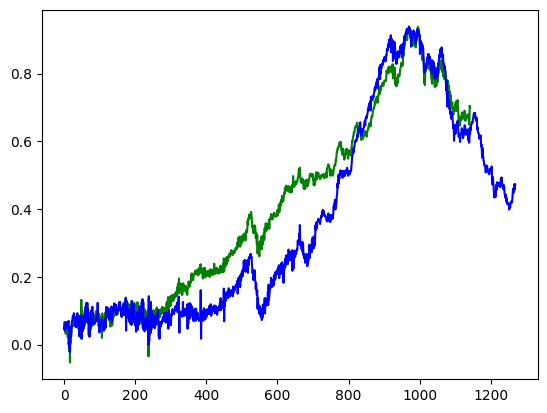

In [ ]:
# compare LSTM on trained on MSFT on predictions for Google
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(LSTM_MSFT_yhat, 'g')
ax.plot(LSTM_GOOG_yhat, 'b')
plt.show()


##4.3 Prophet Model



For this section is how we gonna fit the prophet model by using miscosoft company stock price data. The best hyperparameter we get by using the cross-validation

In [ ]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.model_selection import ParameterGrid

In [ ]:
# Uploaded stock price csv
finance_data = pd.read_csv('/content/StockPrice-Hybrid-Model-/Finance Data/finance.csv')
finance_data.head()

,date,open,high,low,close,adj_close,volume,ticker,10mda,20mda,50mda,100mda,target,EWMA_20,EWMA_50,EWMA_100,rsi,MiddleBand,UpperBand,LowerBand
0,2017-08-04,72.400002,73.040001,72.239998,72.680000,67.571640,22579000,MSFT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-08-07,72.800003,72.900002,72.260002,72.400002,67.311348,18705700,MSFT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-08-08,72.089996,73.129997,71.750000,72.790001,67.673927,22044600,MSFT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-08-09,72.250000,72.510002,72.050003,72.470001,67.376427,22213400,MSFT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-08-10,71.900002,72.190002,71.349998,71.410004,66.390930,24734500,MSFT,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
MSFT_Data = finance_data[finance_data['ticker']=='MSFT']
Google_Data = finance_data[finance_data['ticker']=='GOOG']
# This function is used to get the train data and test data
def data_preparation(df):
  data=df[["date","adj_close"]]
  data = data.rename(columns = {'date':'ds', 'adj_close':'y'})
  return data


In [ ]:
# Define parameter grid to search over
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
}

# Initialize minimum error and best parameters
min_error = float('inf')
best_params = {}

# Loop through all parameter combinations
for params in ParameterGrid(param_grid):
    print('Testing parameters:', params)

    # Initialize Prophet model with specified hyperparameters
    model = Prophet(**params)
    model.fit(data_preparation(MSFT_Data))

    # Perform time series cross-validation
    df_cv = cross_validation(model=model, initial='1000 days', horizon='10 days', period='10 days')

    # Calculate performance metrics
    df_metrics = performance_metrics(df_cv)

    # Calculate mean cross-validation error
    mean_cv_error = df_metrics['mse'].mean()

    # Update minimum error and best parameters if new minimum is found
    if mean_cv_error < min_error:
        min_error = mean_cv_error
        best_params = params

# Print best hyperparameters and corresponding error
print('Best parameters:', best_params)
print('Minimum cross-validation error:', min_error)

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/t0er457k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/ofdn2dte.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17439', 'data', 'file=/tmp/tmpdf26z35w/t0er457k.json', 'init=/tmp/tmpdf26z35w/ofdn2dte.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelpbyp65ql/prophet_model-20230401142054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:20:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:20:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/u_cr36cm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/4ki__0_b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91151', 'data', 'file=/tmp/tmpdf26z35w/u_cr36cm.json', 'init=/tmp/tmpdf26z35w/4ki__0_b.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelx01l9v46/prophet_model-20230401142055.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:20:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:20:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/rkpn4c96.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/v37svaky.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/yozwcx39.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87784', 'data', 'file=/tmp/tmpdf26z35w/e365d3w0.json', 'init=/tmp/tmpdf26z35w/yozwcx39.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_model8vlgf9om/prophet_model-20230401142225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:22:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:22:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/9y48er1e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/e27mvjv4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9479', 'data', 'file=/tmp/tmpdf26z35w/9y48er1e.json', 'init=/tmp/tmpdf26z35w/e27mvjv4.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelw5lhzvk5/prophet_model-20230401142226.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:22:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:22:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/e1c2509s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/hcl0o72l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/li

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


14:23:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/aiuf6z8a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/ruv6etbo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48813', 'data', 'file=/tmp/tmpdf26z35w/aiuf6z8a.json', 'init=/tmp/tmpdf26z35w/ruv6etbo.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_model1ryh46n5/prophet_model-20230401142321.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:23:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:23:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/ewytette.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/kpa9wxlm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


14:24:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/7wxd1qsk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/ynjjkggp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43920', 'data', 'file=/tmp/tmpdf26z35w/7wxd1qsk.json', 'init=/tmp/tmpdf26z35w/ynjjkggp.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelrwat_lut/prophet_model-20230401142419.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:24:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:24:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/1v31vume.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/kctmx3w6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


14:25:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/21zwdilm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/zgd0w4h5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26082', 'data', 'file=/tmp/tmpdf26z35w/21zwdilm.json', 'init=/tmp/tmpdf26z35w/zgd0w4h5.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelwyzdojew/prophet_model-20230401142521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:25:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:25:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/88ia88u5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/z2luslt0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


14:26:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/j2t0ddn2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/g8fascsw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28609', 'data', 'file=/tmp/tmpdf26z35w/j2t0ddn2.json', 'init=/tmp/tmpdf26z35w/g8fascsw.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modeld4vrf36v/prophet_model-20230401142625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:26:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:26:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/o8vrigr2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/680pu3qf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


14:27:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/wovu70s2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/z4gybhzq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16370', 'data', 'file=/tmp/tmpdf26z35w/wovu70s2.json', 'init=/tmp/tmpdf26z35w/z4gybhzq.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_model4rr_6ugs/prophet_model-20230401142752.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:27:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:27:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/ipwrjq7u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/kw86xr5i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


14:29:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/22i_8bz6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/zyy2nxug.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18818', 'data', 'file=/tmp/tmpdf26z35w/22i_8bz6.json', 'init=/tmp/tmpdf26z35w/zyy2nxug.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelzwfo2qe4/prophet_model-20230401142950.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:29:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:29:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/toz6dm4x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/rl0nue96.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/8aptnk2r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67195', 'data', 'file=/tmp/tmpdf26z35w/rsoa3sb9.json', 'init=/tmp/tmpdf26z35w/8aptnk2r.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelg24kcl8w/prophet_model-20230401143150.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:31:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:31:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/x4xo43a1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/9p4e9_ba.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53107', 'data', 'file=/tmp/tmpdf26z35w/x4xo43a1.json', 'init=/tmp/tmpdf26z35w/9p4e9_ba.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modeljd4t3gr9/prophet_model-20230401143152.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:31:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:31:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/cc5zocv5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/ay7ykt_j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/33im4ws2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2541', 'data', 'file=/tmp/tmpdf26z35w/x6qch2tr.json', 'init=/tmp/tmpdf26z35w/33im4ws2.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelof4p1tfq/prophet_model-20230401143352.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:33:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:33:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/h5q27j0_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/60t5hjiu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27166', 'data', 'file=/tmp/tmpdf26z35w/h5q27j0_.json', 'init=/tmp/tmpdf26z35w/60t5hjiu.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_model7vwhhrkv/prophet_model-20230401143354.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:33:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:33:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/vj6a8kah.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/2ona776r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


14:36:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/w0sj6g9d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/3j7curi3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7596', 'data', 'file=/tmp/tmpdf26z35w/w0sj6g9d.json', 'init=/tmp/tmpdf26z35w/3j7curi3.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_model3bbe90u0/prophet_model-20230401143601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:36:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:36:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/_87zyy95.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/q0rth34t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/li

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


14:38:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/r965n7go.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/1dg5o2oj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98923', 'data', 'file=/tmp/tmpdf26z35w/r965n7go.json', 'init=/tmp/tmpdf26z35w/1dg5o2oj.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelst8chku3/prophet_model-20230401143820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:38:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:38:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/vf1mn_qo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/4y32of6f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/zv59p558.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9797', 'data', 'file=/tmp/tmpdf26z35w/qvque2l5.json', 'init=/tmp/tmpdf26z35w/zv59p558.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelv2zfai6h/prophet_model-20230401144157.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:41:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:41:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/fzw6k6w6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/2_r45tf3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58045', 'data', 'file=/tmp/tmpdf26z35w/fzw6k6w6.json', 'init=/tmp/tmpdf26z35w/2_r45tf3.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelv9mj14zl/prophet_model-20230401144159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:41:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:42:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/s34d1dqf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/iq5tl41a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


14:44:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/afue2qmr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/g5hibljd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97626', 'data', 'file=/tmp/tmpdf26z35w/afue2qmr.json', 'init=/tmp/tmpdf26z35w/g5hibljd.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelf5v6v8pi/prophet_model-20230401144444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:44:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:44:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/fsbhnucr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/zulw_erw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/lm2sa070.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38639', 'data', 'file=/tmp/tmpdf26z35w/oudc45eb.json', 'init=/tmp/tmpdf26z35w/lm2sa070.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelczcd96ir/prophet_model-20230401144725.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:47:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:47:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/i_gk_p1t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/nnktmrw6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90222', 'data', 'file=/tmp/tmpdf26z35w/i_gk_p1t.json', 'init=/tmp/tmpdf26z35w/nnktmrw6.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modeltym4fu2i/prophet_model-20230401144726.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:47:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:47:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/tx9tr22g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/3byugpf5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


14:50:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/v75lrfek.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/eyvln51d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35408', 'data', 'file=/tmp/tmpdf26z35w/v75lrfek.json', 'init=/tmp/tmpdf26z35w/eyvln51d.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_modelkqqgm8yb/prophet_model-20230401145005.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:50:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:50:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/mend8r8z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/g_sa8qm0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


14:52:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/2q17ept3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/5gjbn81g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38258', 'data', 'file=/tmp/tmpdf26z35w/2q17ept3.json', 'init=/tmp/tmpdf26z35w/5gjbn81g.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_model5ykjzp3_/prophet_model-20230401145243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:52:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:52:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/5hjy33hm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/2xjxaw4g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


14:55:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 104 forecasts with cutoffs between 2020-05-03 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/104 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/3i5e662e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/71__gz9b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56782', 'data', 'file=/tmp/tmpdf26z35w/3i5e662e.json', 'init=/tmp/tmpdf26z35w/71__gz9b.json', 'output', 'file=/tmp/tmpdf26z35w/prophet_model_aysgm9q/prophet_model-20230401145535.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:55:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:55:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/soj4jwhf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdf26z35w/ffuh4rka.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Best parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}
Minimum cross-validation error: 185.1688513042688


### 4.3.1 Forecasting with Prophet

In [ ]:
def get_data(df):
  Best_parameters={'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}
  # We use the best parameter to fit the model
  final_model = Prophet(**Best_parameters)
  final_model.fit(data_preparation(df))
  df = cross_validation(model=final_model, initial='124 days', horizon='10 days', period='10 days')
  return df

In [ ]:
MSFT_train_data = get_data(MSFT_Data)[['ds', 'yhat']]
MSFT_train_data.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuizjr35d/rkjjvl_y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuizjr35d/4lwnb0a6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95476', 'data', 'file=/tmp/tmpuizjr35d/rkjjvl_y.json', 'init=/tmp/tmpuizjr35d/4lwnb0a6.json', 'output', 'file=/tmp/tmpuizjr35d/prophet_modelyz4tx22g/prophet_model-20230402153308.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:33:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:33:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 191 forecasts with cutoffs between 2017-12-15 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/191 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpuizjr35d/gr4bacuo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuizjr35d/ilrpcdao.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44493', 'data', 'file=/tmp/tmpuizjr35d/gr4bacuo.json', 'init=/tmp/tmpuizjr35d/ilrpcdao.json', 'output', 'file=/tmp/tmpuizjr35d/prophet_modelf2250t7l/prophet_model-20230402153312.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:33:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:33:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuizjr35d/t5zmlz2w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuizjr35d/37ivk5no.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

,ds,yhat
0,2017-12-18,73.970595
1,2017-12-19,68.597337
2,2017-12-20,60.279245
3,2017-12-21,49.091784
4,2017-12-22,34.894607


In [ ]:
Google_train_data = get_data(Google_Data)[['ds', 'yhat']]
Google_train_data.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuizjr35d/zb0745wa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuizjr35d/03fbhud2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30700', 'data', 'file=/tmp/tmpuizjr35d/zb0745wa.json', 'init=/tmp/tmpuizjr35d/03fbhud2.json', 'output', 'file=/tmp/tmpuizjr35d/prophet_model7kc_y3l0/prophet_model-20230402153928.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 191 forecasts with cutoffs between 2017-12-15 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/191 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpuizjr35d/_6avdjle.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuizjr35d/7_qhy6a4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78575', 'data', 'file=/tmp/tmpuizjr35d/_6avdjle.json', 'init=/tmp/tmpuizjr35d/7_qhy6a4.json', 'output', 'file=/tmp/tmpuizjr35d/prophet_model4eswuswy/prophet_model-20230402153931.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:39:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuizjr35d/fce0rt4k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuizjr35d/xxvc53iq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

,ds,yhat
0,2017-12-18,53.406188
1,2017-12-19,53.607782
2,2017-12-20,53.609407
3,2017-12-21,53.306160
4,2017-12-22,52.961331


In [ ]:
def prep_prophet(prophet_pred, data1):
  prophet_pred = prophet_pred.rename(columns = {'ds': 'date'}).set_index('date')
  main_data = data1.join(prophet_pred,how = 'left')
  returned = main_data.loc['2018-01-01':'2023-02-01', 'yhat']
  return returned

goog_data = prep_prophet(Google_train_data, frames[1])[10:]
msft_train_data = prep_prophet(MSFT_train_data, frames[0])[10:1153]
msft_test_data = prep_prophet(MSFT_train_data, frames[0])[1153:]


##4.4 Hybrid Model 

 ### 4.4.1 Define Training Data Using Ouputs from Standalone Models MSFT

In [ ]:
#creating y_hybrid from y_train of the LSTM model
y_hybrid= y_train
print(y_train.shape, y_hybrid.shape)
print(goog_data.shape)

(1143, 1) (1143, 1)
(1270,)


In [ ]:
#verifying that outputs from both the LSTM and Prohet models match in size

print ("LSTM:", LSTM_MSFT_yhat.shape,"\n","Prophet:", msft_train_data.shape)

#merging the the outcomes from the LSTM model and the Prophet model

msft_hybrid = { 'MSFT_PROPHET':np.array(msft_train_data),  'LSTM':LSTM_MSFT_yhat.flatten()}
msft_hybrid_df = pd.DataFrame(msft_hybrid)
#scaling the MSFT_PROPHET column
scaler2 = MinMaxScaler()

reshaped_msft = msft_hybrid_df['MSFT_PROPHET'].to_numpy()
reshaped_msft= reshaped_msft.reshape(-1,1)

scaled_msft = scaler2.fit_transform(reshaped_msft)
msft_hybrid_df['MSFT_Pscaled'] = scaled_msft.flatten()
msft_hybrid_df=msft_hybrid_df.drop('MSFT_PROPHET', axis=1)

#verifying the transform
print("msft hybrid",msft_hybrid_df.shape)
#Defining the data for the hybrid training
X2_ft = np.array(msft_hybrid_df)
print("y_hybrid", y_hybrid.shape)

X_train2,y_train2 = lstm_split(msft_hybrid_df,y_hybrid,len(X2_ft))


LSTM: (1143, 1) 
 Prophet: (1143,)
msft hybrid (1143, 2)
y_hybrid (1143, 1)


In [ ]:
#LSTM Framework for the hybrid model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.metrics import Precision
from keras.optimizers import Adam
import keras_tuner


#Hybrid model architecture and training
LR = 0.01
EPOCH = 100
BATCH = 24
hybrid = Sequential()
hybrid.add(LSTM(units = 98, activation = "relu", input_shape = (X_train2.shape[1], X_train2.shape[2]), return_sequences = False))
hybrid.add(Dropout(0.5))
hybrid.add(Dense(units =1))
hybrid.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = ["mae"])
Early_stop = EarlyStopping(monitor='loss', min_delta=0, 
                           patience=25, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

hybrid_history = hybrid.fit(X_train2, y_train2, epochs = 300, batch_size = 24, callbacks = [Early_stop])
#tune2 = keras_tuner.RandomSearch(build_model, objective= keras_tuner.Objective('val_loss', direction='min'), max_trials = 50, seed = 2)



#hybrid_model = tune.get_best_models()[0]

#hybrid_model.save('/content/StockPrice-Hybrid-Model-/Models/Hybrid_model.h5')
hybrid_history.model.save('/content/StockPrice-Hybrid-Model-/Models/Hybrid_model1.h5')

Epoch 1/300


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


48/48 [==============================] - 2s 12ms/step - loss: 0.0293 - mae: 0.1128
Epoch 2/300
48/48 [==============================] - 1s 12ms/step - loss: 0.0085 - mae: 0.0653
Epoch 3/300
48/48 [==============================] - 1s 11ms/step - loss: 0.0083 - mae: 0.0643
Epoch 4/300
48/48 [==============================] - 1s 11ms/step - loss: 0.0079 - mae: 0.0645
Epoch 5/300
48/48 [==============================] - 1s 11ms/step - loss: 0.0064 - mae: 0.0584
Epoch 6/300
48/48 [==============================] - 0s 10ms/step - loss: 0.0116 - mae: 0.0794
Epoch 7/300
48/48 [==============================] - 0s 10ms/step - loss: 0.0075 - mae: 0.0645
Epoch 8/300
48/48 [==============================] - 1s 11ms/step - loss: 0.0076 - mae: 0.0657
Epoch 9/300
48/48 [==============================] - 0s 10ms/step - loss: 0.0083 - mae: 0.0662
Epoch 10/300
48/48 [==============================] - 0s 10ms/step - loss: 0.0070 - mae: 0.0613
Epoch 11/300
48/48 [==============================] - 0s 10ms

###4.4.2 LOSS and MAE

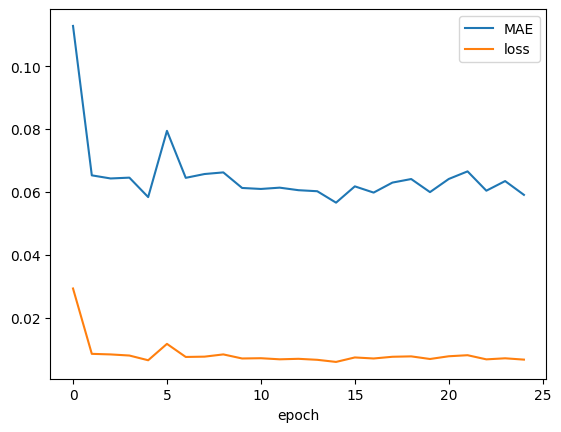

In [ ]:
import matplotlib.pyplot as plt

# plot MAE and loss
#plt.figure(figsize=(10, 6))
plt.plot(hybrid_history.history['mae'], label='MAE')
plt.plot(hybrid_history.history['loss'], label='loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

### 4.4.3 Comparing output of LSTM MSFT and Hybrid MSFT 

In [ ]:
#LSTM_hybrid_yhat = testmodel('/content/StockPrice-Hybrid-Model-/Models/Hybrid_model.h5', X_train2)
from keras.models import load_model
hybrid_yhat = load_model('/content/StockPrice-Hybrid-Model-/Models/Hybrid_model1.h5')
LSTM_hybrid_yhat= hybrid_yhat.predict(X_train2)
LSTM_hybrid_yhat.shape
import matplotlib.pyplot as plt


36/36 [==============================] - 0s 6ms/step


###4.4.4 Hybrid Model Testing on GOOG

In [ ]:
#merge lstm test prediction and prophet test prediction
def merge_predictions(lstm_pred,prophet_pred):
  data_dict = {}
  scaler = MinMaxScaler()
  data_dict['LSTM'] = lstm_pred.flatten()
  data_dict['prophet'] = np.array(prophet_pred)
  hybrid_test_data = pd.DataFrame(data_dict)
  hybrid_test_data['prophet'] = scaler.fit_transform(hybrid_test_data[['prophet']])
  return hybrid_test_data

In [ ]:
print(LSTM_GOOG_yhat.shape,goog_data.shape)
hybrid_test_data= merge_predictions(LSTM_GOOG_yhat, goog_data)
print(hybrid_test_data.shape)

(1270, 1) (1270,)
(1270, 2)


In [ ]:
X1,y1 = lstm_split(hybrid_test_data,google_target,len(hybrid_test_data))
predictions = hybrid.predict(X1)

In [ ]:
def compute_metrics(true_series, forecast):
    """Helper to print MSE and MAE"""
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [ ]:
mse, mae = compute_metrics(y1, predictions)
print(mae)

###4.4.5 Predicted vs Actual Price

In [ ]:

plt.plot(y1, label="actual")
plt.plot(predictions, label="predicted")
plt.xlabel("Timesteps")
plt.ylabel("Value")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.legend()
plt.show()

#5.0 Multiple Company Model

## 5.1 Generate Sub-models

In [ ]:
def create_lists(list_of_df):
  training_list = []
  target_list = []
  for i in range(len(list_of_df)):
    scaler = MinMaxScaler()
    data = list_of_df[i]
    score = data['score']
    target = scaler.fit_transform(data[['target']])
    training = data.drop(['target', 'ticker', 'score'], axis = 1)
    for col in training.columns:
      training[col] = scaler.fit_transform(training[[col]])
    training['score'] = score
    data_x, data_y = lstm_split(training, target, len(training))
    training_list.append(data_x)
    target_list.append(data_y)
  return training_list, target_list

#General LSTM model based on randomsearch results
def multiple_models(x_train, y_train):
    hybrid = Sequential()
    hybrid.add(LSTM(units = 98, activation = "relu", input_shape = (x_train.shape[1], x_train.shape[2]), return_sequences = False))
    hybrid.add(Dropout(0.7))
    hybrid.add(Dense(units =1, activation = 'sigmoid'))
    hybrid.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = ["mean_squared_error"])
    Early_stop = EarlyStopping(monitor='val_loss', min_delta=0, 
                              patience=25, verbose=1, mode='auto',
                              baseline=0, restore_best_weights=True)
    hybrid.fit(x_train, y_train, epochs = 200, batch_size = 24, callbacks = [Early_stop])
    return hybrid

training_list, target_list = create_lists(frames[1:])
for tick, x_train, y_train in zip(ticker_list, training_list, target_list):
  model = multiple_models(x_train, y_train)
  model.save('/content/StockPrice-Hybrid-Model-/sub_models/'+tick+'_lstm.h5')


Epoch 1/200


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


50/53 [===========================>..] - ETA: 0s - loss: 0.0236 - mean_squared_error: 0.0236

53/53 [==============================] - 2s 11ms/step - loss: 0.0231 - mean_squared_error: 0.0231
Epoch 2/200
53/53 [==============================] - ETA: 0s - loss: 0.0094 - mean_squared_error: 0.0094

53/53 [==============================] - 1s 11ms/step - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 3/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0069

53/53 [==============================] - 1s 11ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 4/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 16ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 5/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 14ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 6/200
52/53 [============================>.] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 20ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 7/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 19ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 8/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 17ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 9/200
53/53 [==============================] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 20ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 10/200
52/53 [============================>.] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 26ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 11/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 23ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 12/200
52/53 [============================>.] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 22ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 13/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 22ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 14/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 21ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 15/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 16ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 16/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 18ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 17/200
52/53 [============================>.] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 16ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 18/200
52/53 [============================>.] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 16ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 19/200
53/53 [==============================] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 17ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 20/200
53/53 [==============================] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 21ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 21/200
52/53 [============================>.] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 22ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 22/200
53/53 [==============================] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 26ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 23/200
53/53 [==============================] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 2s 35ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 24/200
53/53 [==============================] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 2s 40ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 25/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 2s 33ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 26/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 2s 31ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 27/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 18ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 28/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 17ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 29/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 16ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 30/200
53/53 [==============================] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 19ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 31/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 16ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 32/200
53/53 [==============================] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 33/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 10ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 34/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 35/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 36/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 37/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 10ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 38/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 39/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 40/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 41/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 13ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 42/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 16ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 43/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 15ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 44/200
53/53 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 15ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 45/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 16ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 46/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 16ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 47/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 48/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 49/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 12ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 50/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 51/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 12ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 52/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 53/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 11ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 54/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 55/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 56/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 57/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 13ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 58/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 59/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 60/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 61/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 62/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 63/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 64/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 17ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 65/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 16ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 66/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 16ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 67/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 16ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 68/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 16ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 69/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 15ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 70/200
52/53 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 71/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 72/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 73/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 12ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 74/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 13ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 75/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 13ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 76/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 77/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 78/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 79/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 80/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 81/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 82/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 83/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 84/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 85/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 86/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 16ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 87/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 16ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 88/200
52/53 [============================>.] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 16ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 89/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 17ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 90/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 16ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 91/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 16ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 92/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 93/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 94/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 95/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 96/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 97/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 98/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 99/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 100/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 11ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 101/200
53/53 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 102/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 11ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 103/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 104/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 105/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 106/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 107/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 108/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 15ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 109/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 16ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 110/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 16ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 111/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 16ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 112/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 17ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 113/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 16ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 114/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 15ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 115/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 116/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 117/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 118/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 119/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 120/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 121/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 14ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 122/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_squared_error: 0.0090

53/53 [==============================] - 1s 11ms/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 123/200
52/53 [============================>.] - ETA: 0s - loss: 0.0083 - mean_squared_error: 0.0083

53/53 [==============================] - 1s 11ms/step - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 124/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 11ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 125/200
52/53 [============================>.] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 11ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 126/200
52/53 [============================>.] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 11ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 127/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 11ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 128/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 11ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 129/200
53/53 [==============================] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 11ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 130/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 11ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 131/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 13ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 132/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 15ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 133/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 15ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 134/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 15ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 135/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 16ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 136/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 20ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 137/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 16ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 138/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 12ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 139/200
52/53 [============================>.] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 11ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 140/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 141/200
52/53 [============================>.] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 11ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 142/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 143/200
53/53 [==============================] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 16ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 144/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 16ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 145/200
53/53 [==============================] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 20ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 146/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 14ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 147/200
52/53 [============================>.] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 22ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 148/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 18ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 149/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 14ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 150/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 19ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 151/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 20ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 152/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 20ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 153/200
53/53 [==============================] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 20ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 154/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 2s 36ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 155/200
52/53 [============================>.] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 23ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 156/200
52/53 [============================>.] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 18ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 157/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 16ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 158/200
52/53 [============================>.] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 16ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 159/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 16ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 160/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 17ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 161/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 19ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 162/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 19ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 163/200
53/53 [==============================] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 18ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 164/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 20ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 165/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 24ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 166/200
53/53 [==============================] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 20ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 167/200
52/53 [============================>.] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 15ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 168/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 21ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 169/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 23ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 170/200
53/53 [==============================] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 25ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 171/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 20ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 172/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 19ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 173/200
52/53 [============================>.] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 21ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 174/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 18ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 175/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 18ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 176/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 16ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 177/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 17ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 178/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 18ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 179/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 25ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 180/200
52/53 [============================>.] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 19ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 181/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 19ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 182/200
52/53 [============================>.] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 23ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 183/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 2s 35ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 184/200
52/53 [============================>.] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 28ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 185/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 27ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 186/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 21ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 187/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 18ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 188/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 17ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 189/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 18ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 190/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 17ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 191/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 16ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 192/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 18ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 193/200
53/53 [==============================] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 18ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 194/200
52/53 [============================>.] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 23ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 195/200
53/53 [==============================] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 19ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 196/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 12ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 197/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 15ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 198/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 16ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 199/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 16ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 200/200
52/53 [============================>.] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 16ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 1/200
52/53 [============================>.] - ETA: 0s - loss: 0.0172 - mean_squared_error: 0.0172

53/53 [==============================] - 2s 12ms/step - loss: 0.0171 - mean_squared_error: 0.0171
Epoch 2/200
53/53 [==============================] - ETA: 0s - loss: 0.0088 - mean_squared_error: 0.0088

53/53 [==============================] - 1s 11ms/step - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 3/200
52/53 [============================>.] - ETA: 0s - loss: 0.0096 - mean_squared_error: 0.0096

53/53 [==============================] - 1s 15ms/step - loss: 0.0095 - mean_squared_error: 0.0095
Epoch 4/200
53/53 [==============================] - ETA: 0s - loss: 0.0085 - mean_squared_error: 0.0085

53/53 [==============================] - 1s 16ms/step - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 5/200
52/53 [============================>.] - ETA: 0s - loss: 0.0085 - mean_squared_error: 0.0085

53/53 [==============================] - 1s 16ms/step - loss: 0.0084 - mean_squared_error: 0.0084
Epoch 6/200
52/53 [============================>.] - ETA: 0s - loss: 0.0071 - mean_squared_error: 0.0071

53/53 [==============================] - 1s 17ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 7/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 1s 19ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 8/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0071 - mean_squared_error: 0.0071

53/53 [==============================] - 1s 17ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 9/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0073 - mean_squared_error: 0.0073

53/53 [==============================] - 1s 14ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 10/200
52/53 [============================>.] - ETA: 0s - loss: 0.0071 - mean_squared_error: 0.0071

53/53 [==============================] - 1s 13ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 11/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 11ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 12/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 11ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 13/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 11ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 14/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 12ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 15/200
53/53 [==============================] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 11ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 16/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 1s 11ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 17/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 11ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 18/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 10ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 19/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 11ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 20/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 12ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 21/200
53/53 [==============================] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 12ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 22/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 12ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 23/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 11ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 24/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 11ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 25/200
52/53 [============================>.] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 13ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 26/200
52/53 [============================>.] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 15ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 27/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 16ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 28/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 15ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 29/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 16ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 30/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 16ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 31/200
52/53 [============================>.] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 16ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 32/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 12ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 33/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 12ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 34/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 13ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 35/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 36/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 12ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 37/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 14ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 38/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 12ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 39/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 12ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 40/200
53/53 [==============================] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 12ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 41/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 11ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 42/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 12ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 43/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 11ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 44/200
53/53 [==============================] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 45/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 12ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 46/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 13ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 47/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 13ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 48/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 20ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 49/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 15ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 50/200
53/53 [==============================] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 15ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 51/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 18ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 52/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 17ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 53/200
53/53 [==============================] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 24ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 54/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 22ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 55/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 21ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 56/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 17ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 57/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 18ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 58/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 23ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 59/200
52/53 [============================>.] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 2s 36ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 60/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 2s 33ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 61/200
52/53 [============================>.] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 28ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 62/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 2s 43ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 63/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 2s 36ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 64/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 27ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 65/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 2s 34ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 66/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 2s 35ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 67/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 22ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 68/200
53/53 [==============================] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 19ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 69/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 20ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 70/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 20ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 71/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 20ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 72/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 20ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 73/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 19ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 74/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 19ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 75/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 23ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 76/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 24ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 77/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 24ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 78/200
53/53 [==============================] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 2s 30ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 79/200
52/53 [============================>.] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 26ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 80/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 2s 33ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 81/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 2s 36ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 82/200
52/53 [============================>.] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 2s 30ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 83/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 26ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 84/200
53/53 [==============================] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 22ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 85/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 19ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 86/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 19ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 87/200
53/53 [==============================] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 23ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 88/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 2s 29ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 89/200
52/53 [============================>.] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 23ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 90/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 2s 31ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 91/200
53/53 [==============================] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 2s 29ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 92/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 2s 36ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 93/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 27ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 94/200
52/53 [============================>.] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 20ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 95/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 21ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 96/200
53/53 [==============================] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 21ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 97/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 20ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 98/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 17ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 99/200
52/53 [============================>.] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 19ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 100/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 19ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 101/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 21ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 102/200
53/53 [==============================] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 25ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 103/200
52/53 [============================>.] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 24ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 104/200
52/53 [============================>.] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 23ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 105/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 27ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 106/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 25ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 107/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 23ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 108/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 22ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 109/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 12ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 110/200
53/53 [==============================] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 12ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 111/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 13ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 112/200
53/53 [==============================] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 12ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 113/200
52/53 [============================>.] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 12ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 114/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 12ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 115/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 12ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 116/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 12ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 117/200
53/53 [==============================] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 12ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 118/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 119/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 13ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 120/200
52/53 [============================>.] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 17ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 121/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 25ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 122/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 25ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 123/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 2s 29ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 124/200
53/53 [==============================] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 27ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 125/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 24ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 126/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 20ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 127/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 20ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 128/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 19ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 129/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 22ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 130/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 18ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 131/200
53/53 [==============================] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 18ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 132/200
53/53 [==============================] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 21ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 133/200
53/53 [==============================] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 18ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 134/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 22ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 135/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 25ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 136/200
52/53 [============================>.] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 2s 28ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 137/200
53/53 [==============================] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 2s 30ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 138/200
52/53 [============================>.] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 2s 31ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 139/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 2s 31ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 140/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 21ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 141/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 20ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 142/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 19ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 143/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 18ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 144/200
52/53 [============================>.] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 17ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 145/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 19ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 146/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 18ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 147/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 19ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 148/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 20ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 149/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 19ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 150/200
52/53 [============================>.] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 18ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 151/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 23ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 152/200
53/53 [==============================] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 28ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 153/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 22ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 154/200
52/53 [============================>.] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 23ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 155/200
53/53 [==============================] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 27ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 156/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 2s 30ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 157/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 23ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 158/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 27ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 159/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 2s 30ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 160/200
53/53 [==============================] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 2s 29ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 161/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 2s 29ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 162/200
53/53 [==============================] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 27ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 163/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 27ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 164/200
53/53 [==============================] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 26ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 165/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 23ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 166/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 24ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 167/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 23ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 168/200
53/53 [==============================] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 19ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 169/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 23ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 170/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 16ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 171/200
52/53 [============================>.] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0069

53/53 [==============================] - 1s 18ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 172/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 18ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 173/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 20ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 174/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 18ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 175/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 15ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 176/200
53/53 [==============================] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 19ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 177/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 20ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 178/200
52/53 [============================>.] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 27ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 179/200
52/53 [============================>.] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 26ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 180/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 23ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 181/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 28ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 182/200
52/53 [============================>.] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 2s 30ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 183/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 2s 36ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 184/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 24ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 185/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 22ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 186/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 17ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 187/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 18ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 188/200
52/53 [============================>.] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 17ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 189/200
52/53 [============================>.] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 18ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 190/200
52/53 [============================>.] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 17ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 191/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 18ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 192/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 18ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 193/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 20ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 194/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 24ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 195/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 22ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 196/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 22ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 197/200
52/53 [============================>.] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 24ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 198/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 27ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 199/200
53/53 [==============================] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 25ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 200/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 18ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 1/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0209 - mean_squared_error: 0.0209

53/53 [==============================] - 2s 14ms/step - loss: 0.0204 - mean_squared_error: 0.0204
Epoch 2/200
53/53 [==============================] - ETA: 0s - loss: 0.0104 - mean_squared_error: 0.0104

53/53 [==============================] - 1s 14ms/step - loss: 0.0104 - mean_squared_error: 0.0104
Epoch 3/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0084 - mean_squared_error: 0.0084

53/53 [==============================] - 1s 12ms/step - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 4/200
53/53 [==============================] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 12ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 5/200
53/53 [==============================] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 12ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 6/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 14ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 7/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 12ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 8/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 12ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 9/200
52/53 [============================>.] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 18ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 10/200
52/53 [============================>.] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 19ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 11/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 18ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 12/200
52/53 [============================>.] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 15ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 13/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 16ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 14/200
53/53 [==============================] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 16ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 15/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 17ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 16/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 17ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 17/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 13ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 18/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 14ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 19/200
53/53 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 13ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 20/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 12ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 21/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 12ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 22/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 12ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 23/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 12ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 24/200
53/53 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 12ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 25/200
52/53 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 12ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 26/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 27/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 28/200
52/53 [============================>.] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 12ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 29/200
53/53 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 12ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 30/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 12ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 31/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 12ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 32/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 17ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 33/200
52/53 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 15ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 34/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 16ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 35/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 15ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 36/200
53/53 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 16ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 37/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 17ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 38/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 18ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 39/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 16ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 40/200
53/53 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 12ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 41/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 12ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 42/200
53/53 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 12ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 43/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 14ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 44/200
52/53 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 22ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 45/200
52/53 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 21ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 46/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 21ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 47/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 18ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 48/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 18ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 49/200
53/53 [==============================] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 18ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 50/200
53/53 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 21ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 51/200
53/53 [==============================] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 22ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 52/200
52/53 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 26ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 53/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 22ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 54/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 25ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 55/200
52/53 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 28ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 56/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 22ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 57/200
52/53 [============================>.] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 17ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 58/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 18ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 59/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 21ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 60/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 20ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 61/200
52/53 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 24ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 62/200
53/53 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 24ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 63/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 20ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 64/200
53/53 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 15ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 65/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 18ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 66/200
52/53 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 22ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 67/200
53/53 [==============================] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 22ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 68/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 22ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 69/200
52/53 [============================>.] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 22ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 70/200
52/53 [============================>.] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 26ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 71/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 24ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 72/200
52/53 [============================>.] - ETA: 0s - loss: 0.0077 - mean_squared_error: 0.0077

53/53 [==============================] - 1s 21ms/step - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 73/200
52/53 [============================>.] - ETA: 0s - loss: 0.0090 - mean_squared_error: 0.0090

53/53 [==============================] - 1s 20ms/step - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 74/200
53/53 [==============================] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

53/53 [==============================] - 1s 19ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 75/200
53/53 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 18ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 76/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0083 - mean_squared_error: 0.0083

53/53 [==============================] - 1s 18ms/step - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 77/200
52/53 [============================>.] - ETA: 0s - loss: 0.0092 - mean_squared_error: 0.0092

53/53 [==============================] - 1s 16ms/step - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 78/200
53/53 [==============================] - ETA: 0s - loss: 0.0102 - mean_squared_error: 0.0102

53/53 [==============================] - 1s 18ms/step - loss: 0.0102 - mean_squared_error: 0.0102
Epoch 79/200
53/53 [==============================] - ETA: 0s - loss: 0.0223 - mean_squared_error: 0.0223

53/53 [==============================] - 1s 26ms/step - loss: 0.0223 - mean_squared_error: 0.0223
Epoch 80/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0156 - mean_squared_error: 0.0156

53/53 [==============================] - 2s 29ms/step - loss: 0.0158 - mean_squared_error: 0.0158
Epoch 81/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0116 - mean_squared_error: 0.0116

53/53 [==============================] - 1s 22ms/step - loss: 0.0113 - mean_squared_error: 0.0113
Epoch 82/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 2s 32ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 83/200
53/53 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 26ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 84/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 22ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 85/200
53/53 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 23ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 86/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 22ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 87/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 25ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 88/200
53/53 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 20ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 89/200
52/53 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 18ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 90/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 17ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 91/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 16ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 92/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 16ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 93/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 19ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 94/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 17ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 95/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 21ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 96/200
52/53 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 21ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 97/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 21ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 98/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 24ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 99/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 25ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 100/200
53/53 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 24ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 101/200
53/53 [==============================] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 26ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 102/200
53/53 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 26ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 103/200
53/53 [==============================] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 24ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 104/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 20ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 105/200
53/53 [==============================] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 20ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 106/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 19ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 107/200
52/53 [============================>.] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 15ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 108/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 18ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 109/200
52/53 [============================>.] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 18ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 110/200
52/53 [============================>.] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 21ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 111/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 21ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 112/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 20ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 113/200
52/53 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 19ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 114/200
52/53 [============================>.] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 2s 32ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 115/200
52/53 [============================>.] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 2s 35ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 116/200
53/53 [==============================] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 2s 32ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 117/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 2s 30ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 118/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 2s 30ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 119/200
52/53 [============================>.] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 23ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 120/200
53/53 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 22ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 121/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 20ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 122/200
52/53 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 18ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 123/200
53/53 [==============================] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 25ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 124/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 22ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 125/200
52/53 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 22ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 126/200
52/53 [============================>.] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 22ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 127/200
53/53 [==============================] - ETA: 0s - loss: 0.0105 - mean_squared_error: 0.0105

53/53 [==============================] - 2s 30ms/step - loss: 0.0105 - mean_squared_error: 0.0105
Epoch 128/200
52/53 [============================>.] - ETA: 0s - loss: 0.0156 - mean_squared_error: 0.0156

53/53 [==============================] - 2s 34ms/step - loss: 0.0155 - mean_squared_error: 0.0155
Epoch 129/200
53/53 [==============================] - ETA: 0s - loss: 0.0145 - mean_squared_error: 0.0145

53/53 [==============================] - 2s 31ms/step - loss: 0.0145 - mean_squared_error: 0.0145
Epoch 130/200
53/53 [==============================] - ETA: 0s - loss: 0.0123 - mean_squared_error: 0.0123

53/53 [==============================] - 2s 31ms/step - loss: 0.0123 - mean_squared_error: 0.0123
Epoch 131/200
53/53 [==============================] - ETA: 0s - loss: 0.0110 - mean_squared_error: 0.0110

53/53 [==============================] - 2s 35ms/step - loss: 0.0110 - mean_squared_error: 0.0110
Epoch 132/200
52/53 [============================>.] - ETA: 0s - loss: 0.0181 - mean_squared_error: 0.0181

53/53 [==============================] - 2s 29ms/step - loss: 0.0182 - mean_squared_error: 0.0182
Epoch 133/200
52/53 [============================>.] - ETA: 0s - loss: 0.0126 - mean_squared_error: 0.0126

53/53 [==============================] - 1s 23ms/step - loss: 0.0126 - mean_squared_error: 0.0126
Epoch 134/200
53/53 [==============================] - ETA: 0s - loss: 0.0085 - mean_squared_error: 0.0085

53/53 [==============================] - 1s 21ms/step - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 135/200
53/53 [==============================] - ETA: 0s - loss: 0.0082 - mean_squared_error: 0.0082

53/53 [==============================] - 2s 35ms/step - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 136/200
53/53 [==============================] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

53/53 [==============================] - 2s 44ms/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 137/200
52/53 [============================>.] - ETA: 0s - loss: 0.0077 - mean_squared_error: 0.0077

53/53 [==============================] - 2s 37ms/step - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 138/200
53/53 [==============================] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0069

53/53 [==============================] - 3s 50ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 139/200
52/53 [============================>.] - ETA: 0s - loss: 0.0073 - mean_squared_error: 0.0073

53/53 [==============================] - 3s 54ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 140/200
52/53 [============================>.] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 3s 55ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 141/200
52/53 [============================>.] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 2s 35ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 142/200
52/53 [============================>.] - ETA: 0s - loss: 0.0071 - mean_squared_error: 0.0071

53/53 [==============================] - 1s 26ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 143/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0069

53/53 [==============================] - 1s 27ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 144/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

53/53 [==============================] - 1s 28ms/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 145/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 24ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 146/200
52/53 [============================>.] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 23ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 147/200
52/53 [============================>.] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 25ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 148/200
53/53 [==============================] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 2s 30ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 149/200
52/53 [============================>.] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 2s 30ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 150/200
53/53 [==============================] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 2s 31ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 151/200
52/53 [============================>.] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 2s 33ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 152/200
53/53 [==============================] - ETA: 0s - loss: 0.0089 - mean_squared_error: 0.0089

53/53 [==============================] - 2s 32ms/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 153/200
52/53 [============================>.] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 1s 24ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 154/200
52/53 [============================>.] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 20ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 155/200
53/53 [==============================] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 2s 29ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 156/200
52/53 [============================>.] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 27ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 157/200
52/53 [============================>.] - ETA: 0s - loss: 0.0079 - mean_squared_error: 0.0079

53/53 [==============================] - 1s 26ms/step - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 158/200
52/53 [============================>.] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

53/53 [==============================] - 1s 27ms/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 159/200
52/53 [============================>.] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 23ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 160/200
52/53 [============================>.] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 25ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 161/200
52/53 [============================>.] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 2s 31ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 162/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 27ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 163/200
53/53 [==============================] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 2s 28ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 164/200
53/53 [==============================] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 2s 30ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 165/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 2s 31ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 166/200
52/53 [============================>.] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 1s 25ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 167/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 23ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 168/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 25ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 169/200
52/53 [============================>.] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 24ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 170/200
52/53 [============================>.] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 23ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 171/200
53/53 [==============================] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 20ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 172/200
53/53 [==============================] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 20ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 173/200
53/53 [==============================] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 2s 28ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 174/200
53/53 [==============================] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 24ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 175/200
53/53 [==============================] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 24ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 176/200
53/53 [==============================] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 22ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 177/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 22ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 178/200
53/53 [==============================] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 25ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 179/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 22ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 180/200
53/53 [==============================] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 25ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 181/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 19ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 182/200
53/53 [==============================] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 18ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 183/200
53/53 [==============================] - ETA: 0s - loss: 0.0070 - mean_squared_error: 0.0070

53/53 [==============================] - 1s 18ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 184/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_squared_error: 0.0070

53/53 [==============================] - 1s 18ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 185/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 19ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 186/200
52/53 [============================>.] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 19ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 187/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 19ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 188/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 17ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 189/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 19ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 190/200
53/53 [==============================] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 14ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 191/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 16ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 192/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 17ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 193/200
52/53 [============================>.] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 15ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 194/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 15ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 195/200
53/53 [==============================] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 15ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 196/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 17ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 197/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 16ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 198/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 18ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 199/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 17ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 200/200
53/53 [==============================] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 14ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 1/200
52/53 [============================>.] - ETA: 0s - loss: 0.0204 - mean_squared_error: 0.0204

53/53 [==============================] - 6s 31ms/step - loss: 0.0202 - mean_squared_error: 0.0202
Epoch 2/200
52/53 [============================>.] - ETA: 0s - loss: 0.0080 - mean_squared_error: 0.0080

53/53 [==============================] - 2s 43ms/step - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 3/200
52/53 [============================>.] - ETA: 0s - loss: 0.0074 - mean_squared_error: 0.0074

53/53 [==============================] - 2s 39ms/step - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 4/200
52/53 [============================>.] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 2s 35ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 5/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 2s 32ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 6/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 26ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 7/200
52/53 [============================>.] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 2s 33ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 8/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 2s 29ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 9/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 2s 31ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 10/200
52/53 [============================>.] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 28ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 11/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 24ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 12/200
53/53 [==============================] - ETA: 0s - loss: 0.0082 - mean_squared_error: 0.0082

53/53 [==============================] - 1s 25ms/step - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 13/200
53/53 [==============================] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 2s 34ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 14/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 2s 38ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 15/200
52/53 [============================>.] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 2s 29ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 16/200
53/53 [==============================] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 2s 35ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 17/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 18ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 18/200
52/53 [============================>.] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 27ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 19/200
52/53 [============================>.] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 2s 31ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 20/200
52/53 [============================>.] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 20ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 21/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 19ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 22/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 18ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 23/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 18ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 24/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 18ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 25/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 21ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 26/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 23ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 27/200
52/53 [============================>.] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 28ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 28/200
52/53 [============================>.] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 2s 33ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 29/200
53/53 [==============================] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 28ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 30/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 27ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 31/200
52/53 [============================>.] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 24ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 32/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 18ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 33/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 21ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 34/200
53/53 [==============================] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 18ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 35/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 12ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 36/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 12ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 37/200
52/53 [============================>.] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 12ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 38/200
52/53 [============================>.] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 12ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 39/200
52/53 [============================>.] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 12ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 40/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 12ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 41/200
52/53 [============================>.] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 12ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 42/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 12ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 43/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 13ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 44/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 15ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 45/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 18ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 46/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 25ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 47/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 2s 32ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 48/200
53/53 [==============================] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 2s 32ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 49/200
52/53 [============================>.] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 2s 33ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 50/200
53/53 [==============================] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 2s 32ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 51/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 23ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 52/200
52/53 [============================>.] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 21ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 53/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 20ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 54/200
52/53 [============================>.] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 19ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 55/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 19ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 56/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 20ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 57/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 19ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 58/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 17ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 59/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 21ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 60/200
53/53 [==============================] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 26ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 61/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 27ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 62/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 20ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 63/200
52/53 [============================>.] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 17ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 64/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 19ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 65/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 23ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 66/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 15ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 67/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 12ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 68/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 13ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 69/200
52/53 [============================>.] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 14ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 70/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 14ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 71/200
52/53 [============================>.] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 15ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 72/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 15ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 73/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 12ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 74/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 13ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 75/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 14ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 76/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 13ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 77/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 12ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 78/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 13ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 79/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 13ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 80/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 16ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 81/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 16ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 82/200
52/53 [============================>.] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 17ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 83/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 18ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 84/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 18ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 85/200
52/53 [============================>.] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 19ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 86/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 20ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 87/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 18ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 88/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 13ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 89/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 13ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 90/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 12ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 91/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 92/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 13ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 93/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 13ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 94/200
52/53 [============================>.] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 12ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 95/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 13ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 96/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 13ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 97/200
53/53 [==============================] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 12ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 98/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 12ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 99/200
53/53 [==============================] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 13ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 100/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 12ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 101/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 12ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 102/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 14ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 103/200
53/53 [==============================] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 20ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 104/200
53/53 [==============================] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 19ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 105/200
53/53 [==============================] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 20ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 106/200
52/53 [============================>.] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 18ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 107/200
52/53 [============================>.] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 16ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 108/200
53/53 [==============================] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 21ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 109/200
53/53 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 20ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 110/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 16ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 111/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 112/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 13ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 113/200
53/53 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 13ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 114/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 13ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 115/200
53/53 [==============================] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 13ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 116/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 13ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 117/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 15ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 118/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 15ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 119/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 15ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 120/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 16ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 121/200
52/53 [============================>.] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 15ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 122/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 13ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 123/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 13ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 124/200
52/53 [============================>.] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 18ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 125/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 19ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 126/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 19ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 127/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 16ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 128/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 18ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 129/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 19ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 130/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 19ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 131/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 17ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 132/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 14ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 133/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 134/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 135/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 13ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 136/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 13ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 137/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 13ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 138/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 139/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 12ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 140/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 13ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 141/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 15ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 142/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 15ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 143/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 15ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 144/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 12ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 145/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 12ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 146/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 15ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 147/200
53/53 [==============================] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 16ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 148/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 15ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 149/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 20ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 150/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 18ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 151/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 16ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 152/200
52/53 [============================>.] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 19ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 153/200
52/53 [============================>.] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 18ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 154/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 16ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 155/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 13ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 156/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 12ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 157/200
53/53 [==============================] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 12ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 158/200
52/53 [============================>.] - ETA: 0s - loss: 0.0072 - mean_squared_error: 0.0072

53/53 [==============================] - 1s 13ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 159/200
53/53 [==============================] - ETA: 0s - loss: 0.0070 - mean_squared_error: 0.0070

53/53 [==============================] - 1s 12ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 160/200
53/53 [==============================] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 12ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 161/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 13ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 162/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 12ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 163/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 12ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 164/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 13ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 165/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 12ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 166/200
52/53 [============================>.] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 13ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 167/200
52/53 [============================>.] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 13ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 168/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 15ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 169/200
52/53 [============================>.] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 18ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 170/200
53/53 [==============================] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 19ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 171/200
52/53 [============================>.] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 16ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 172/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 17ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 173/200
53/53 [==============================] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 16ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 174/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 19ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 175/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 20ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 176/200
53/53 [==============================] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 18ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 177/200
53/53 [==============================] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 18ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 178/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 15ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 179/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 15ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 180/200
53/53 [==============================] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 13ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 181/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 12ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 182/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 14ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 183/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 13ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 184/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 13ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 185/200
52/53 [============================>.] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 13ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 186/200
53/53 [==============================] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 13ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 187/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 12ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 188/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 13ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 189/200
52/53 [============================>.] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 12ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 190/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 12ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 191/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 13ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 192/200
53/53 [==============================] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 19ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 193/200
52/53 [============================>.] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 19ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 194/200
52/53 [============================>.] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 15ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 195/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 15ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 196/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 17ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 197/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 19ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 198/200
53/53 [==============================] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 20ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 199/200
52/53 [============================>.] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 20ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 200/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 13ms/step - loss: 0.0051 - mean_squared_error: 0.0051


### 5.1.1 Configure Hybrid Training Set and Train Hybrid Model

In [ ]:
import os
def multiple_models(x_train, y_train):
    hybrid = Sequential()
    hybrid.add(LSTM(units = 98, activation = "relu", input_shape = (x_train.shape[1], x_train.shape[2]), return_sequences = False))
    hybrid.add(Dropout(0.7))
    hybrid.add(Dense(units =1, activation = 'sigmoid'))
    hybrid.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = ["mean_squared_error"])
    Early_stop = EarlyStopping(monitor='val_loss', min_delta=0, 
                              patience=25, verbose=1, mode='auto',
                              baseline=0, restore_best_weights=True)
    hybrid.fit(x_train, y_train, epochs = 200, batch_size = 24, callbacks = [Early_stop])
    return hybrid

def hybrid_train(direct, ticker_list, hybrid_train, prophet, targets):
    preds_dict = {}
    path = direct
    scaler = MinMaxScaler()
    for num, model in enumerate(os.listdir(path)):
        model = load_model(path+model)
        prediction = model.predict(hybrid_train).flatten()
        preds_dict[ticker_list[num]] = prediction
    preds_df = pd.DataFrame(preds_dict)
    preds_df['prophet'] = np.array(prophet)
    preds_df['prophet'] = scaler.fit_transform(preds_df[['prophet']])
    x1,y1 = lstm_split(preds_df, targets, len(preds_df))
    return x1, y1

ticker_list = ["MSFT", "NFLX", "AMZN", "TSLA"]
hybrid_training_data, targets =  hybrid_train('/content/StockPrice-Hybrid-Model-/sub_models/', ticker_list, X_train, msft_train_data, y_train) 
hybrid_expanded = multiple_models(hybrid_training_data, targets)

36/36 [==============================] - 1s 9ms/step


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/200
47/48 [============================>.] - ETA: 0s - loss: 0.0387 - mean_squared_error: 0.0387

48/48 [==============================] - 5s 25ms/step - loss: 0.0388 - mean_squared_error: 0.0388
Epoch 2/200
47/48 [============================>.] - ETA: 0s - loss: 0.0344 - mean_squared_error: 0.0344

48/48 [==============================] - 1s 24ms/step - loss: 0.0345 - mean_squared_error: 0.0345
Epoch 3/200
47/48 [============================>.] - ETA: 0s - loss: 0.0348 - mean_squared_error: 0.0348

48/48 [==============================] - 1s 11ms/step - loss: 0.0349 - mean_squared_error: 0.0349
Epoch 4/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0343 - mean_squared_error: 0.0343

48/48 [==============================] - 0s 10ms/step - loss: 0.0346 - mean_squared_error: 0.0346
Epoch 5/200
47/48 [============================>.] - ETA: 0s - loss: 0.0340 - mean_squared_error: 0.0340

48/48 [==============================] - 1s 11ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 6/200
47/48 [============================>.] - ETA: 0s - loss: 0.0339 - mean_squared_error: 0.0339

48/48 [==============================] - 0s 10ms/step - loss: 0.0338 - mean_squared_error: 0.0338
Epoch 7/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0310 - mean_squared_error: 0.0310

48/48 [==============================] - 0s 10ms/step - loss: 0.0311 - mean_squared_error: 0.0311
Epoch 8/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.0338

48/48 [==============================] - 0s 10ms/step - loss: 0.0346 - mean_squared_error: 0.0346
Epoch 9/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0346 - mean_squared_error: 0.0346

48/48 [==============================] - 1s 11ms/step - loss: 0.0345 - mean_squared_error: 0.0345
Epoch 10/200
48/48 [==============================] - ETA: 0s - loss: 0.0345 - mean_squared_error: 0.0345

48/48 [==============================] - 0s 10ms/step - loss: 0.0345 - mean_squared_error: 0.0345
Epoch 11/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0350 - mean_squared_error: 0.0350

48/48 [==============================] - 1s 10ms/step - loss: 0.0347 - mean_squared_error: 0.0347
Epoch 12/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0340 - mean_squared_error: 0.0340

48/48 [==============================] - 0s 10ms/step - loss: 0.0341 - mean_squared_error: 0.0341
Epoch 13/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0349 - mean_squared_error: 0.0349

48/48 [==============================] - 0s 10ms/step - loss: 0.0350 - mean_squared_error: 0.0350
Epoch 14/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0348 - mean_squared_error: 0.0348

48/48 [==============================] - 1s 11ms/step - loss: 0.0344 - mean_squared_error: 0.0344
Epoch 15/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0347 - mean_squared_error: 0.0347

48/48 [==============================] - 0s 10ms/step - loss: 0.0343 - mean_squared_error: 0.0343
Epoch 16/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0348 - mean_squared_error: 0.0348

48/48 [==============================] - 1s 14ms/step - loss: 0.0343 - mean_squared_error: 0.0343
Epoch 17/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0347 - mean_squared_error: 0.0347

48/48 [==============================] - 1s 14ms/step - loss: 0.0341 - mean_squared_error: 0.0341
Epoch 18/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0343 - mean_squared_error: 0.0343

48/48 [==============================] - 1s 15ms/step - loss: 0.0340 - mean_squared_error: 0.0340
Epoch 19/200
47/48 [============================>.] - ETA: 0s - loss: 0.0339 - mean_squared_error: 0.0339

48/48 [==============================] - 1s 15ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 20/200
47/48 [============================>.] - ETA: 0s - loss: 0.0327 - mean_squared_error: 0.0327

48/48 [==============================] - 1s 18ms/step - loss: 0.0329 - mean_squared_error: 0.0329
Epoch 21/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 1s 15ms/step - loss: 0.0344 - mean_squared_error: 0.0344
Epoch 22/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0343 - mean_squared_error: 0.0343

48/48 [==============================] - 1s 16ms/step - loss: 0.0347 - mean_squared_error: 0.0347
Epoch 23/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0344 - mean_squared_error: 0.0344

48/48 [==============================] - 0s 10ms/step - loss: 0.0344 - mean_squared_error: 0.0344
Epoch 24/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0345 - mean_squared_error: 0.0345

48/48 [==============================] - 0s 10ms/step - loss: 0.0346 - mean_squared_error: 0.0346
Epoch 25/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0349 - mean_squared_error: 0.0349

48/48 [==============================] - 0s 10ms/step - loss: 0.0344 - mean_squared_error: 0.0344
Epoch 26/200
48/48 [==============================] - ETA: 0s - loss: 0.0344 - mean_squared_error: 0.0344

48/48 [==============================] - 0s 10ms/step - loss: 0.0344 - mean_squared_error: 0.0344
Epoch 27/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0345 - mean_squared_error: 0.0345

48/48 [==============================] - 0s 10ms/step - loss: 0.0342 - mean_squared_error: 0.0342
Epoch 28/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0345 - mean_squared_error: 0.0345

48/48 [==============================] - 1s 10ms/step - loss: 0.0345 - mean_squared_error: 0.0345
Epoch 29/200
48/48 [==============================] - ETA: 0s - loss: 0.0341 - mean_squared_error: 0.0341

48/48 [==============================] - 1s 11ms/step - loss: 0.0341 - mean_squared_error: 0.0341
Epoch 30/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0329 - mean_squared_error: 0.0329

48/48 [==============================] - 0s 10ms/step - loss: 0.0343 - mean_squared_error: 0.0343
Epoch 31/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0352 - mean_squared_error: 0.0352

48/48 [==============================] - 0s 10ms/step - loss: 0.0345 - mean_squared_error: 0.0345
Epoch 32/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 1s 11ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 33/200
47/48 [============================>.] - ETA: 0s - loss: 0.0347 - mean_squared_error: 0.0347

48/48 [==============================] - 1s 11ms/step - loss: 0.0348 - mean_squared_error: 0.0348
Epoch 34/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.0338

48/48 [==============================] - 0s 10ms/step - loss: 0.0344 - mean_squared_error: 0.0344
Epoch 35/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0340 - mean_squared_error: 0.0340

48/48 [==============================] - 1s 10ms/step - loss: 0.0343 - mean_squared_error: 0.0343
Epoch 36/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0337 - mean_squared_error: 0.0337

48/48 [==============================] - 0s 10ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 37/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0341 - mean_squared_error: 0.0341

48/48 [==============================] - 1s 11ms/step - loss: 0.0341 - mean_squared_error: 0.0341
Epoch 38/200
47/48 [============================>.] - ETA: 0s - loss: 0.0347 - mean_squared_error: 0.0347

48/48 [==============================] - 0s 10ms/step - loss: 0.0346 - mean_squared_error: 0.0346
Epoch 39/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0347 - mean_squared_error: 0.0347

48/48 [==============================] - 0s 10ms/step - loss: 0.0342 - mean_squared_error: 0.0342
Epoch 40/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0346 - mean_squared_error: 0.0346

48/48 [==============================] - 0s 10ms/step - loss: 0.0343 - mean_squared_error: 0.0343
Epoch 41/200
47/48 [============================>.] - ETA: 0s - loss: 0.0341 - mean_squared_error: 0.0341

48/48 [==============================] - 1s 11ms/step - loss: 0.0342 - mean_squared_error: 0.0342
Epoch 42/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0343 - mean_squared_error: 0.0343

48/48 [==============================] - 1s 12ms/step - loss: 0.0342 - mean_squared_error: 0.0342
Epoch 43/200
47/48 [============================>.] - ETA: 0s - loss: 0.0342 - mean_squared_error: 0.0342

48/48 [==============================] - 1s 15ms/step - loss: 0.0343 - mean_squared_error: 0.0343
Epoch 44/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0340 - mean_squared_error: 0.0340

48/48 [==============================] - 1s 15ms/step - loss: 0.0341 - mean_squared_error: 0.0341
Epoch 45/200
48/48 [==============================] - ETA: 0s - loss: 0.0341 - mean_squared_error: 0.0341

48/48 [==============================] - 1s 15ms/step - loss: 0.0341 - mean_squared_error: 0.0341
Epoch 46/200
48/48 [==============================] - ETA: 0s - loss: 0.0343 - mean_squared_error: 0.0343

48/48 [==============================] - 1s 15ms/step - loss: 0.0343 - mean_squared_error: 0.0343
Epoch 47/200
48/48 [==============================] - ETA: 0s - loss: 0.0342 - mean_squared_error: 0.0342

48/48 [==============================] - 1s 16ms/step - loss: 0.0342 - mean_squared_error: 0.0342
Epoch 48/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0339 - mean_squared_error: 0.0339

48/48 [==============================] - 1s 17ms/step - loss: 0.0340 - mean_squared_error: 0.0340
Epoch 49/200
47/48 [============================>.] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.0338

48/48 [==============================] - 1s 14ms/step - loss: 0.0338 - mean_squared_error: 0.0338
Epoch 50/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 1s 12ms/step - loss: 0.0344 - mean_squared_error: 0.0344
Epoch 51/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0339 - mean_squared_error: 0.0339

48/48 [==============================] - 0s 10ms/step - loss: 0.0341 - mean_squared_error: 0.0341
Epoch 52/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0347 - mean_squared_error: 0.0347

48/48 [==============================] - 1s 11ms/step - loss: 0.0340 - mean_squared_error: 0.0340
Epoch 53/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0340 - mean_squared_error: 0.0340

48/48 [==============================] - 0s 10ms/step - loss: 0.0341 - mean_squared_error: 0.0341
Epoch 54/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0330 - mean_squared_error: 0.0330

48/48 [==============================] - 0s 10ms/step - loss: 0.0338 - mean_squared_error: 0.0338
Epoch 55/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0335 - mean_squared_error: 0.0335

48/48 [==============================] - 1s 10ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 56/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0340 - mean_squared_error: 0.0340

48/48 [==============================] - 1s 10ms/step - loss: 0.0343 - mean_squared_error: 0.0343
Epoch 57/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0337 - mean_squared_error: 0.0337

48/48 [==============================] - 1s 11ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 58/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0343 - mean_squared_error: 0.0343

48/48 [==============================] - 0s 10ms/step - loss: 0.0342 - mean_squared_error: 0.0342
Epoch 59/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0352 - mean_squared_error: 0.0352

48/48 [==============================] - 0s 10ms/step - loss: 0.0345 - mean_squared_error: 0.0345
Epoch 60/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0340 - mean_squared_error: 0.0340

48/48 [==============================] - 1s 11ms/step - loss: 0.0342 - mean_squared_error: 0.0342
Epoch 61/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0343 - mean_squared_error: 0.0343

48/48 [==============================] - 0s 10ms/step - loss: 0.0345 - mean_squared_error: 0.0345
Epoch 62/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0340 - mean_squared_error: 0.0340

48/48 [==============================] - 1s 11ms/step - loss: 0.0346 - mean_squared_error: 0.0346
Epoch 63/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.0338

48/48 [==============================] - 1s 11ms/step - loss: 0.0341 - mean_squared_error: 0.0341
Epoch 64/200
48/48 [==============================] - ETA: 0s - loss: 0.0339 - mean_squared_error: 0.0339

48/48 [==============================] - 1s 12ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 65/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0347 - mean_squared_error: 0.0347

48/48 [==============================] - 1s 11ms/step - loss: 0.0345 - mean_squared_error: 0.0345
Epoch 66/200
47/48 [============================>.] - ETA: 0s - loss: 0.0344 - mean_squared_error: 0.0344

48/48 [==============================] - 1s 11ms/step - loss: 0.0343 - mean_squared_error: 0.0343
Epoch 67/200
48/48 [==============================] - ETA: 0s - loss: 0.0341 - mean_squared_error: 0.0341

48/48 [==============================] - 1s 11ms/step - loss: 0.0341 - mean_squared_error: 0.0341
Epoch 68/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0347 - mean_squared_error: 0.0347

48/48 [==============================] - 1s 15ms/step - loss: 0.0343 - mean_squared_error: 0.0343
Epoch 69/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0342 - mean_squared_error: 0.0342

48/48 [==============================] - 1s 16ms/step - loss: 0.0341 - mean_squared_error: 0.0341
Epoch 70/200
48/48 [==============================] - ETA: 0s - loss: 0.0344 - mean_squared_error: 0.0344

48/48 [==============================] - 1s 15ms/step - loss: 0.0344 - mean_squared_error: 0.0344
Epoch 71/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0342 - mean_squared_error: 0.0342

48/48 [==============================] - 1s 17ms/step - loss: 0.0340 - mean_squared_error: 0.0340
Epoch 72/200
47/48 [============================>.] - ETA: 0s - loss: 0.0342 - mean_squared_error: 0.0342

48/48 [==============================] - 1s 17ms/step - loss: 0.0340 - mean_squared_error: 0.0340
Epoch 73/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0342 - mean_squared_error: 0.0342

48/48 [==============================] - 1s 22ms/step - loss: 0.0344 - mean_squared_error: 0.0344
Epoch 74/200
47/48 [============================>.] - ETA: 0s - loss: 0.0340 - mean_squared_error: 0.0340

48/48 [==============================] - 1s 15ms/step - loss: 0.0341 - mean_squared_error: 0.0341
Epoch 75/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0340 - mean_squared_error: 0.0340

48/48 [==============================] - 1s 12ms/step - loss: 0.0343 - mean_squared_error: 0.0343
Epoch 76/200
47/48 [============================>.] - ETA: 0s - loss: 0.0340 - mean_squared_error: 0.0340

48/48 [==============================] - 1s 11ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 77/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0331 - mean_squared_error: 0.0331

48/48 [==============================] - 1s 10ms/step - loss: 0.0341 - mean_squared_error: 0.0341
Epoch 78/200
47/48 [============================>.] - ETA: 0s - loss: 0.0341 - mean_squared_error: 0.0341

48/48 [==============================] - 1s 11ms/step - loss: 0.0340 - mean_squared_error: 0.0340
Epoch 79/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 0s 10ms/step - loss: 0.0340 - mean_squared_error: 0.0340
Epoch 80/200
48/48 [==============================] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.0338

48/48 [==============================] - 1s 12ms/step - loss: 0.0338 - mean_squared_error: 0.0338
Epoch 81/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0334 - mean_squared_error: 0.0334

48/48 [==============================] - 1s 12ms/step - loss: 0.0336 - mean_squared_error: 0.0336
Epoch 82/200
48/48 [==============================] - ETA: 0s - loss: 0.0339 - mean_squared_error: 0.0339

48/48 [==============================] - 1s 12ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 83/200
48/48 [==============================] - ETA: 0s - loss: 0.0342 - mean_squared_error: 0.0342

48/48 [==============================] - 1s 11ms/step - loss: 0.0342 - mean_squared_error: 0.0342
Epoch 84/200
47/48 [============================>.] - ETA: 0s - loss: 0.0344 - mean_squared_error: 0.0344

48/48 [==============================] - 1s 12ms/step - loss: 0.0343 - mean_squared_error: 0.0343
Epoch 85/200
48/48 [==============================] - ETA: 0s - loss: 0.0340 - mean_squared_error: 0.0340

48/48 [==============================] - 1s 12ms/step - loss: 0.0340 - mean_squared_error: 0.0340
Epoch 86/200
47/48 [============================>.] - ETA: 0s - loss: 0.0336 - mean_squared_error: 0.0336

48/48 [==============================] - 1s 11ms/step - loss: 0.0336 - mean_squared_error: 0.0336
Epoch 87/200
48/48 [==============================] - ETA: 0s - loss: 0.0345 - mean_squared_error: 0.0345

48/48 [==============================] - 1s 11ms/step - loss: 0.0345 - mean_squared_error: 0.0345
Epoch 88/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0323 - mean_squared_error: 0.0323

48/48 [==============================] - 1s 10ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 89/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0331 - mean_squared_error: 0.0331

48/48 [==============================] - 1s 11ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 90/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0345 - mean_squared_error: 0.0345

48/48 [==============================] - 0s 10ms/step - loss: 0.0345 - mean_squared_error: 0.0345
Epoch 91/200
48/48 [==============================] - ETA: 0s - loss: 0.0344 - mean_squared_error: 0.0344

48/48 [==============================] - 1s 11ms/step - loss: 0.0344 - mean_squared_error: 0.0344
Epoch 92/200
48/48 [==============================] - ETA: 0s - loss: 0.0339 - mean_squared_error: 0.0339

48/48 [==============================] - 1s 11ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 93/200
47/48 [============================>.] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.0338

48/48 [==============================] - 1s 13ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 94/200
47/48 [============================>.] - ETA: 0s - loss: 0.0340 - mean_squared_error: 0.0340

48/48 [==============================] - 1s 16ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 95/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0337 - mean_squared_error: 0.0337

48/48 [==============================] - 1s 15ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 96/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0343 - mean_squared_error: 0.0343

48/48 [==============================] - 1s 15ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 97/200
47/48 [============================>.] - ETA: 0s - loss: 0.0339 - mean_squared_error: 0.0339

48/48 [==============================] - 1s 16ms/step - loss: 0.0340 - mean_squared_error: 0.0340
Epoch 98/200
48/48 [==============================] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.0338

48/48 [==============================] - 1s 16ms/step - loss: 0.0338 - mean_squared_error: 0.0338
Epoch 99/200
47/48 [============================>.] - ETA: 0s - loss: 0.0339 - mean_squared_error: 0.0339

48/48 [==============================] - 1s 17ms/step - loss: 0.0342 - mean_squared_error: 0.0342
Epoch 100/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0340 - mean_squared_error: 0.0340

48/48 [==============================] - 1s 15ms/step - loss: 0.0340 - mean_squared_error: 0.0340
Epoch 101/200
48/48 [==============================] - ETA: 0s - loss: 0.0339 - mean_squared_error: 0.0339

48/48 [==============================] - 1s 10ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 102/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0335 - mean_squared_error: 0.0335

48/48 [==============================] - 1s 11ms/step - loss: 0.0336 - mean_squared_error: 0.0336
Epoch 103/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 1s 11ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 104/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0339 - mean_squared_error: 0.0339

48/48 [==============================] - 1s 10ms/step - loss: 0.0344 - mean_squared_error: 0.0344
Epoch 105/200
47/48 [============================>.] - ETA: 0s - loss: 0.0345 - mean_squared_error: 0.0345

48/48 [==============================] - 0s 10ms/step - loss: 0.0346 - mean_squared_error: 0.0346
Epoch 106/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0345 - mean_squared_error: 0.0345

48/48 [==============================] - 1s 11ms/step - loss: 0.0342 - mean_squared_error: 0.0342
Epoch 107/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0343 - mean_squared_error: 0.0343

48/48 [==============================] - 1s 11ms/step - loss: 0.0340 - mean_squared_error: 0.0340
Epoch 108/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0341 - mean_squared_error: 0.0341

48/48 [==============================] - 0s 10ms/step - loss: 0.0344 - mean_squared_error: 0.0344
Epoch 109/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0336 - mean_squared_error: 0.0336

48/48 [==============================] - 0s 10ms/step - loss: 0.0340 - mean_squared_error: 0.0340
Epoch 110/200
48/48 [==============================] - ETA: 0s - loss: 0.0341 - mean_squared_error: 0.0341

48/48 [==============================] - 1s 11ms/step - loss: 0.0341 - mean_squared_error: 0.0341
Epoch 111/200
47/48 [============================>.] - ETA: 0s - loss: 0.0341 - mean_squared_error: 0.0341

48/48 [==============================] - 1s 11ms/step - loss: 0.0341 - mean_squared_error: 0.0341
Epoch 112/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0337 - mean_squared_error: 0.0337

48/48 [==============================] - 1s 11ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 113/200
47/48 [============================>.] - ETA: 0s - loss: 0.0340 - mean_squared_error: 0.0340

48/48 [==============================] - 0s 10ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 114/200
48/48 [==============================] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 1s 11ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 115/200
47/48 [============================>.] - ETA: 0s - loss: 0.0342 - mean_squared_error: 0.0342

48/48 [==============================] - 1s 11ms/step - loss: 0.0341 - mean_squared_error: 0.0341
Epoch 116/200
48/48 [==============================] - ETA: 0s - loss: 0.0341 - mean_squared_error: 0.0341

48/48 [==============================] - 1s 11ms/step - loss: 0.0341 - mean_squared_error: 0.0341
Epoch 117/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0344 - mean_squared_error: 0.0344

48/48 [==============================] - 0s 10ms/step - loss: 0.0343 - mean_squared_error: 0.0343
Epoch 118/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0328 - mean_squared_error: 0.0328

48/48 [==============================] - 1s 11ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 119/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0346 - mean_squared_error: 0.0346

48/48 [==============================] - 1s 11ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 120/200
47/48 [============================>.] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 1s 15ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 121/200
48/48 [==============================] - ETA: 0s - loss: 0.0340 - mean_squared_error: 0.0340

48/48 [==============================] - 1s 17ms/step - loss: 0.0340 - mean_squared_error: 0.0340
Epoch 122/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0339 - mean_squared_error: 0.0339

48/48 [==============================] - 1s 18ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 123/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0325 - mean_squared_error: 0.0325

48/48 [==============================] - 1s 18ms/step - loss: 0.0340 - mean_squared_error: 0.0340
Epoch 124/200
48/48 [==============================] - ETA: 0s - loss: 0.0336 - mean_squared_error: 0.0336

48/48 [==============================] - 1s 16ms/step - loss: 0.0336 - mean_squared_error: 0.0336
Epoch 125/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0330 - mean_squared_error: 0.0330

48/48 [==============================] - 1s 16ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 126/200
47/48 [============================>.] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.0338

48/48 [==============================] - 1s 13ms/step - loss: 0.0338 - mean_squared_error: 0.0338
Epoch 127/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0344 - mean_squared_error: 0.0344

48/48 [==============================] - 1s 11ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 128/200
47/48 [============================>.] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 1s 11ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 129/200
48/48 [==============================] - ETA: 0s - loss: 0.0341 - mean_squared_error: 0.0341

48/48 [==============================] - 1s 11ms/step - loss: 0.0341 - mean_squared_error: 0.0341
Epoch 130/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0344 - mean_squared_error: 0.0344

48/48 [==============================] - 1s 12ms/step - loss: 0.0341 - mean_squared_error: 0.0341
Epoch 131/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0337 - mean_squared_error: 0.0337

48/48 [==============================] - 1s 11ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 132/200
48/48 [==============================] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.0338

48/48 [==============================] - 1s 11ms/step - loss: 0.0338 - mean_squared_error: 0.0338
Epoch 133/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0339 - mean_squared_error: 0.0339

48/48 [==============================] - 0s 10ms/step - loss: 0.0342 - mean_squared_error: 0.0342
Epoch 134/200
47/48 [============================>.] - ETA: 0s - loss: 0.0337 - mean_squared_error: 0.0337

48/48 [==============================] - 1s 11ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 135/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0329 - mean_squared_error: 0.0329

48/48 [==============================] - 1s 12ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 136/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0346 - mean_squared_error: 0.0346

48/48 [==============================] - 1s 12ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 137/200
48/48 [==============================] - ETA: 0s - loss: 0.0335 - mean_squared_error: 0.0335

48/48 [==============================] - 1s 11ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 138/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0341 - mean_squared_error: 0.0341

48/48 [==============================] - 1s 12ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 139/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 1s 11ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 140/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0340 - mean_squared_error: 0.0340

48/48 [==============================] - 1s 11ms/step - loss: 0.0338 - mean_squared_error: 0.0338
Epoch 141/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0341 - mean_squared_error: 0.0341

48/48 [==============================] - 1s 11ms/step - loss: 0.0340 - mean_squared_error: 0.0340
Epoch 142/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0344 - mean_squared_error: 0.0344

48/48 [==============================] - 1s 11ms/step - loss: 0.0341 - mean_squared_error: 0.0341
Epoch 143/200
48/48 [==============================] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.0338

48/48 [==============================] - 1s 12ms/step - loss: 0.0338 - mean_squared_error: 0.0338
Epoch 144/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 1s 11ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 145/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0343 - mean_squared_error: 0.0343

48/48 [==============================] - 1s 16ms/step - loss: 0.0341 - mean_squared_error: 0.0341
Epoch 146/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0339 - mean_squared_error: 0.0339

48/48 [==============================] - 1s 14ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 147/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0334 - mean_squared_error: 0.0334

48/48 [==============================] - 1s 14ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 148/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0341 - mean_squared_error: 0.0341

48/48 [==============================] - 1s 16ms/step - loss: 0.0338 - mean_squared_error: 0.0338
Epoch 149/200
47/48 [============================>.] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 1s 17ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 150/200
47/48 [============================>.] - ETA: 0s - loss: 0.0336 - mean_squared_error: 0.0336

48/48 [==============================] - 1s 16ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 151/200
48/48 [==============================] - ETA: 0s - loss: 0.0334 - mean_squared_error: 0.0334

48/48 [==============================] - 1s 15ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 152/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0341 - mean_squared_error: 0.0341

48/48 [==============================] - 1s 13ms/step - loss: 0.0341 - mean_squared_error: 0.0341
Epoch 153/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0340 - mean_squared_error: 0.0340

48/48 [==============================] - 0s 10ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 154/200
48/48 [==============================] - ETA: 0s - loss: 0.0336 - mean_squared_error: 0.0336

48/48 [==============================] - 1s 11ms/step - loss: 0.0336 - mean_squared_error: 0.0336
Epoch 155/200
47/48 [============================>.] - ETA: 0s - loss: 0.0335 - mean_squared_error: 0.0335

48/48 [==============================] - 1s 11ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 156/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0336 - mean_squared_error: 0.0336

48/48 [==============================] - 1s 11ms/step - loss: 0.0336 - mean_squared_error: 0.0336
Epoch 157/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0334 - mean_squared_error: 0.0334

48/48 [==============================] - 1s 11ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 158/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0340 - mean_squared_error: 0.0340

48/48 [==============================] - 1s 11ms/step - loss: 0.0338 - mean_squared_error: 0.0338
Epoch 159/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.0338

48/48 [==============================] - 1s 14ms/step - loss: 0.0336 - mean_squared_error: 0.0336
Epoch 160/200
48/48 [==============================] - ETA: 0s - loss: 0.0335 - mean_squared_error: 0.0335

48/48 [==============================] - 1s 14ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 161/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0340 - mean_squared_error: 0.0340

48/48 [==============================] - 1s 13ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 162/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0339 - mean_squared_error: 0.0339

48/48 [==============================] - 1s 14ms/step - loss: 0.0336 - mean_squared_error: 0.0336
Epoch 163/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.0338

48/48 [==============================] - 1s 13ms/step - loss: 0.0338 - mean_squared_error: 0.0338
Epoch 164/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0343 - mean_squared_error: 0.0343

48/48 [==============================] - 1s 11ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 165/200
47/48 [============================>.] - ETA: 0s - loss: 0.0337 - mean_squared_error: 0.0337

48/48 [==============================] - 1s 11ms/step - loss: 0.0336 - mean_squared_error: 0.0336
Epoch 166/200
47/48 [============================>.] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 1s 11ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 167/200
47/48 [============================>.] - ETA: 0s - loss: 0.0334 - mean_squared_error: 0.0334

48/48 [==============================] - 1s 11ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 168/200
47/48 [============================>.] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 1s 11ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 169/200
47/48 [============================>.] - ETA: 0s - loss: 0.0338 - mean_squared_error: 0.0338

48/48 [==============================] - 1s 15ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 170/200
47/48 [============================>.] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 1s 18ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 171/200
47/48 [============================>.] - ETA: 0s - loss: 0.0335 - mean_squared_error: 0.0335

48/48 [==============================] - 1s 17ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 172/200
47/48 [============================>.] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 1s 16ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 173/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 1s 16ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 174/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0336 - mean_squared_error: 0.0336

48/48 [==============================] - 1s 16ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 175/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0341 - mean_squared_error: 0.0341

48/48 [==============================] - 1s 17ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 176/200
48/48 [==============================] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 1s 14ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 177/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0336 - mean_squared_error: 0.0336

48/48 [==============================] - 1s 13ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 178/200
47/48 [============================>.] - ETA: 0s - loss: 0.0334 - mean_squared_error: 0.0334

48/48 [==============================] - 1s 14ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 179/200
47/48 [============================>.] - ETA: 0s - loss: 0.0334 - mean_squared_error: 0.0334

48/48 [==============================] - 1s 12ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 180/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0336 - mean_squared_error: 0.0336

48/48 [==============================] - 1s 12ms/step - loss: 0.0338 - mean_squared_error: 0.0338
Epoch 181/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0331 - mean_squared_error: 0.0331

48/48 [==============================] - 1s 11ms/step - loss: 0.0336 - mean_squared_error: 0.0336
Epoch 182/200
47/48 [============================>.] - ETA: 0s - loss: 0.0335 - mean_squared_error: 0.0335

48/48 [==============================] - 1s 11ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 183/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0339 - mean_squared_error: 0.0339

48/48 [==============================] - 1s 11ms/step - loss: 0.0336 - mean_squared_error: 0.0336
Epoch 184/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0346 - mean_squared_error: 0.0346

48/48 [==============================] - 1s 11ms/step - loss: 0.0338 - mean_squared_error: 0.0338
Epoch 185/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0337 - mean_squared_error: 0.0337

48/48 [==============================] - 1s 11ms/step - loss: 0.0338 - mean_squared_error: 0.0338
Epoch 186/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0339 - mean_squared_error: 0.0339

48/48 [==============================] - 1s 12ms/step - loss: 0.0336 - mean_squared_error: 0.0336
Epoch 187/200
47/48 [============================>.] - ETA: 0s - loss: 0.0335 - mean_squared_error: 0.0335

48/48 [==============================] - 1s 14ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 188/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0330 - mean_squared_error: 0.0330

48/48 [==============================] - 1s 14ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 189/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 1s 11ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 190/200
47/48 [============================>.] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 1s 11ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 191/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0325 - mean_squared_error: 0.0325

48/48 [==============================] - 1s 14ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 192/200
48/48 [==============================] - ETA: 0s - loss: 0.0339 - mean_squared_error: 0.0339

48/48 [==============================] - 1s 13ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 193/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0339 - mean_squared_error: 0.0339

48/48 [==============================] - 1s 17ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 194/200
48/48 [==============================] - ETA: 0s - loss: 0.0332 - mean_squared_error: 0.0332

48/48 [==============================] - 1s 16ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 195/200
48/48 [==============================] - ETA: 0s - loss: 0.0331 - mean_squared_error: 0.0331

48/48 [==============================] - 1s 15ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 196/200
47/48 [============================>.] - ETA: 0s - loss: 0.0333 - mean_squared_error: 0.0333

48/48 [==============================] - 1s 16ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 197/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0331 - mean_squared_error: 0.0331

48/48 [==============================] - 1s 17ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 198/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0335 - mean_squared_error: 0.0335

48/48 [==============================] - 1s 16ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 199/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0326 - mean_squared_error: 0.0326

48/48 [==============================] - 1s 16ms/step - loss: 0.0334 - mean_squared_error: 0.0334
Epoch 200/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0329 - mean_squared_error: 0.0329

48/48 [==============================] - 1s 13ms/step - loss: 0.0332 - mean_squared_error: 0.0332


In [ ]:
hybrid_expanded.save('/content/StockPrice-Hybrid-Model-/Models/hybrid_expanded.h5')

### 5.1.2 Test the Expanded Model

In [ ]:
from os import listdir
hybrid_expanded = load_model('/content/StockPrice-Hybrid-Model-/Models/hybrid_expanded.h5')
google_test = {}
microsoft_test = {}
path = '/content/StockPrice-Hybrid-Model-/sub_models/'
for num, model in enumerate(os.listdir(path)):
  model = load_model(path+model)
  goog_preds = model.predict(google_ft).flatten()
  micro_preds = model.predict(X_test).flatten()
  google_test[ticker_list[num]] = goog_preds
  microsoft_test[ticker_list[num]] = micro_preds
google_test = pd.DataFrame(google_test)
microsoft_test = pd.DataFrame(microsoft_test)

goog_x, goog_y = lstm_split(google_test, google_target, len(google_test))
msft_x, msft_y = lstm_split(microsoft_test, y_test, len(microsoft_test))


4/4 [==============================] - 0s 6ms/step


In [ ]:
import matplotlib.pyplot as plt

# plot MAE and loss
#plt.figure(figsize=(10, 6))
plt.plot(hybrid_history.history['mae'], label='MAE')
plt.plot(hybrid_history.history['loss'], label='loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

def compute_metrics(true_series, forecast):
    """Helper to print MSE and MAE"""
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

# compare LSTM on trained on MSFT on predictions for Google
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(LSTM_MSFT_yhat, 'g')
ax.plot(LSTM_GOOG_yhat, 'b')
plt.show()